In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install http://sourceforge.net/projects/matplotlib/files/matplotlib-toolkits/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759602 sha256=9132aaf7e6347893796d59b10853cf0ade67d0bd907e08286f68d110f4c5bb13
  Stored in directory: /tmp/pip-ephem-wheel-cache-_5ut2j9m/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap
     |████████████████████████████████| 256kB 730kB/s 
  ERROR: Cannot unpack file /tmp/pip-unpack-pszkr7r_/matplotlib-toolkits (downloaded 

In [3]:
!pip install netcdf4
!pip install pyMCR
!pip install geopandas

     |████████████████████████████████| 921kB 5.5MB/s 
  Created wheel for pyMCR: filename=pyMCR-0.3.2-cp37-none-any.whl size=26497 sha256=1c13ee1c3bacead9485cd74c6e8b95a90e6de95b339bed3c672c70e4f4d1e3c2
  Stored in directory: /root/.cache/pip/wheels/bf/61/c2/59ca0fb0ad90a9f608586e960a20e03449982e39d88ab2be2f
Successfully built pyMCR
     |████████████████████████████████| 1.0MB 6.5MB/s 
     |████████████████████████████████| 15.4MB 202kB/s 


# Libraries

In [4]:
#!/bin/env python
import sys
import glob
import os
import re
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from scipy.interpolate import griddata
import torch
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from skimage import measure, transform
#from skimage.segmentation import slic
#from skimage.segmentation import mark_boundaries
from skimage import io
from skimage import data, segmentation, color
from scipy.ndimage import label, generate_binary_structure
from scipy.spatial import distance
from scipy import ndimage
from shapely.geometry import Point, LineString, Polygon, LinearRing, MultiPoint
from descartes import PolygonPatch
import networkx as nx
import tarfile
import string
import calendar
import cv2
import random
from google.colab.patches import cv2_imshow
from mpl_toolkits.basemap import Basemap,cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4
from geopandas import GeoSeries
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.metrics.pairwise import euclidean_distances




In [20]:
DIR_DATA = '/content/drive/MyDrive/LIPADE/DATA/'
DIR_TRAIN = '/content/drive/MyDrive/LIPADE/LABELS/'
DIR_TEST = '/content/drive/MyDrive/StageUParis/Test/'

# Class **PollutionTracker**

In [291]:
class PollutionTracker():  
  image_type = "LT"
  year = 2008
  month = 5
  day = 1

  degree = 0.625
  pixel_size = 0.3125
  vmax = 35
  vmin = 10

  north_max = 55
  
  weight_gray_values = 1
  N_CLUSTERS = 2

  images = list()

  def __init__ (self,DIR_DATA=DIR_DATA, DIR_TRAIN=DIR_TRAIN):
    self.DIR_DATA = DIR_DATA
    self.DIR_TRAIN = DIR_TRAIN

  def __del__(self):
    print("Class finished")


  ############################################################################
  ####                      GETTERS AND SETTERS
  ############################################################################

  def set_DIR_DATA (self, DIR_DATA):
    self.DIR_DATA = DIR_DATA

  def get_DIR_DATA (self):
    return self.DIR_DATA

  def set_DIR_TRAIN (self, DIR_TRAIN):
    self.DIR_TRAIN = DIR_TRAIN
  
  def get_DIR_TRAIN (self):
    return self.DIR_TRAIN

  def set_DIR_TEST (self, DIR_TEST):
    self.DIR_TEST = DIR_TEST

  def get_DIR_TEST (self):
    return self.DIR_TEST

  def set_year(self,year):
    self.year = year

  def get_year(self):
    return self.year
  
  def set_month(self,month):
    self.month = month
  
  def get_month(self):
    return self.month

  def set_day(self,day):
    self.day = day

  def get_day(self):
    return self.day

  def set_image_type(self,image_type):
    self.image_type = image_type

  def get_image_type(self):
    return self.image_type

  def set_image_name(self,image_name):
    self.image_name = image_name

  def get_image_name(self):
    return self.image_name

  def set_pixel_size(self, degree, size):
    self.degree = degree
    self.pixel_size = size

  def set_region_area(self, max_area, min_area):
    self.max_area = max_area
    self.min_area = min_area

  def set_weight_gray_values(self, weight_gray_values):
    self.weight_gray_values = weight_gray_values

  def set_cluster_value (self, N_CLUSTERS):
    self.N_CLUSTERS = N_CLUSTERS

  def get_cluster_value(self):
    return self.N_CLUSTERS

  def set_vmin(self, vmin):
    self.vmin = vmin

  def get_vmin(self):
    return self.vmin
  
  def set_vmax(self, vmax):
    self.vmax = vmax

  def get_vmax(self):
    return self.vmax






  ############################################################################
  ####                        READ THE DATA
  ############################################################################

  def get_image_by_leves (self):
    #for index, layer in enumerate(np.arange(self.start, self.end, self.steps)):
    index = 0
    
    lat_g = np.arange(20.,self.north_max,self.degree)
    lon_g = np.arange(100.,150.,self.degree)

    #self.lat_g = lat_g
    #self.lon_g = lon_g

    #initialization
    self.colgrid = np.zeros([lat_g.shape[0],lon_g.shape[0]], np.uint8)

    for year in range(self.year, self.year + 1):
      for month in range(self.month, self.month + 1):
        for day in range(self.day, self.day + 1):

          fname = self.DIR_DATA + 'IASIdaily_' + str(year) + '%02d'%month+'%02d'%day+'.nc'
          self.image_name = self.image_type + '-level-' + str(year) + '%02d'%month+'%02d'%day+'.png'

          print('reading info ...')

          if not(os.path.isfile(fname)):
            continue

          nc = netCDF4.Dataset(fname)
          flag = nc.variables['flag'][:]
          mask1 = (flag == 0) # Without clouds
          
          lat = nc.variables['lat'][mask1]
          lon = nc.variables['lon'][mask1]
          col = nc.variables[self.image_type][mask1]
          o3_conc = nc.variables['o3conc'][mask1]
          nc.close()

          highest_conc = list()
          for i in range(len(o3_conc)):
            highest_conc.append(np.argmax(o3_conc[i]))

          mask2 = (np.isnan(col) == False) 

          # gridding the data
          for ilat in range(lat_g.shape[0]):
            for ilon in range(lon_g.shape[0]):
              # Grille régulier
              # 25 km
              # 0 25 degrée lattitude et longitude

              # Grille regulier of 0.125 degree
              maskgrid = (lat[:] >= (lat_g[ilat] - self.pixel_size)) & (lat[:] < (lat_g[ilat] + self.pixel_size)) & (lon[:] >= (lon_g[ilon] - self.pixel_size)) & (lon[:] < (lon_g[ilon] + self.pixel_size))
              
              # Defining invalid data
              mask = mask2 & maskgrid

              if len(col[mask]) != 0:
                median = np.mean(col[mask])
                #if median >= np.mean(highest_conc):
                self.colgrid[ilat,ilon] = median

          print('data have been read correctly')

          # We mark the values at colgrid as invalid because they are maybe false positives or bad sampling
          self.colgrid1 = ma.masked_values(self.colgrid, 0.)

          self.v_x, self.v_y = np.meshgrid(lon_g, lat_g)
          gradx, grady = np.gradient(self.colgrid, edge_order=1)

          fig, (ax1) = plt.subplots(1, 1, figsize = (11,8))
          ax1.pcolormesh(self.v_x, self.v_y, self.colgrid, shading='nearest',cmap='gray', vmin=self.vmin, vmax=self.vmax)
          ax1.axis('off')
          fig.savefig(self.image_name, bbox_inches='tight', pad_inches=0)
          plt.close(fig)


          fig2, (ax2) = plt.subplots(1, 1, figsize = (11,8))
          ax2.pcolormesh(self.v_x, self.v_y, self.colgrid1, shading='nearest',cmap='jet', vmin=self.vmin, vmax=self.vmax)
          ax2.axis('off')
          fig2.savefig("color-" + self.image_name, bbox_inches='tight', pad_inches=0)
          plt.close(fig2)


  def get_image_datename(self):
    return ' IASI ' + self.image_type + " - " + str(self.day) +"/"+ str(self.month) +"/"+ str(self.year)



  def plot_original_image(self):

    #if self.image_type == 'LT':
    #  vmax = 35
    #  vmin = 3
    #else:
    #  vmax = 45
    #  vmin = 5

    fig, ax1 = plt.subplots(1,1)
    
    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=self.north_max,resolution='i')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    m.drawparallels(np.r_[20:self.north_max:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='1%', pad=0.05)
    cs = ax1.pcolormesh(self.v_x, self.v_y, self.colgrid1, shading='nearest',cmap='jet', vmin=self.vmin, vmax=self.vmax)
    ax1.set_title(self.get_image_datename())
    fig.colorbar(cs,cax=cax)
    


  ###############################################################
  ###             LOAD IMAGE INFORMATION
  ###############################################################

  def load_image_from_files (self, filename):
    img_bgr = io.imread(filename) 
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    return img_bgr, gray





  ###############################################################
  ###             TRAITEMENT
  ###############################################################

  def filter_image (self, image):
    image = self.resize_image_percentage(image, 100)
    image = self.pretraitement_image(image,6,3)
    background, foreground = self.masking_interest_region(image)

    self.foreground = foreground
    
    return image, foreground, background

  def resize_image_percentage (self, image, scale_percent = 100):
    ### SCALE
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    return image

  def pretraitement_image(self, image, kernel_size = 9, iterations=3):
    ### MORPHO FILTERS
    kernel = np.ones((kernel_size,kernel_size),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations = iterations)

    return image

  ## REMOVING THE HOLES
  def masking_interest_region(self, image):
    # Take the holes (pixels value = 0) and set it as 255
    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])), 0, self.vmax, cv2.NORM_MINMAX )
    image = np.where(image == 0, 255, image) 
    image = np.where(image != 255, 0, image) # This is the mask of the background
    image_holes_dilate = cv2.morphologyEx(image, cv2.MORPH_DILATE, np.ones((3,3),np.uint8), iterations = 3)
    image_holes_dilate_inv = cv2.bitwise_not(image_holes_dilate) # This is the mask of the foreground

    return image_holes_dilate, image_holes_dilate_inv

  def filter_image_for_mser(self, image, foreground):
    #kernel = np.ones((3,3),np.uint8)
    #foreground = cv2.dilate(foreground,kernel,iterations = 3)
    
    image = cv2.bitwise_and(image,image, mask=foreground)

    image_masked = ma.masked_values(image, 0.)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image_color = cv2.bitwise_and(image_color,image_color, mask=foreground)
  
    return image, image_color, image_masked
  
  ## REMOVING THE HOLES
  

  def get_mser_regions(self, image):
    """
    delta	          it compares (sizei−sizei−delta)/sizei−delta
    min_area	      prune the area which smaller than minArea
    max_area	      prune the area which bigger than maxArea
    max_variation	  prune the area have similar size to its children
    min_diversity	  for color image, trace back to cut off mser with diversity less than min_diversity
    max_evolution	  for color image, the evolution steps
    area_threshold	for color image, the area threshold to cause re-initialize
    min_margin	    for color image, ignore too small margin
    edge_blur_size	for color image, the aperture size for edge blur
    """

    if self.image_type == "LT":
      mser = cv2.MSER_create( 1, # delta 
                          100, # min_area
                          34400, #max_area 
                          4., # max_variation 
                          .03, # min_diversity 
                          10000, # max_evolution 
                          1.04, # area_threshold 
                          0.003, # min_margin
                          3) # edge_blur_size
    else:
      mser = cv2.MSER_create( 1, # delta 
                          500, # min_area
                          50000, #max_area 
                          4., # max_variation 
                          .03, # min_diversity 
                          10000, # max_evolution 
                          1.03, # area_threshold 
                          0.03, # min_margin
                          3) # edge_blur_size

    # (1, 100, 20000, .25, 1., 1000, 1.001, 0.003, 5)
    regions, bboxes = mser.detectRegions(image)
    regions = sorted(regions, key=cv2.contourArea, reverse=True)
    bboxes = sorted(bboxes, key=self.sort_boxes_by_area, reverse=True)

    print("REGIONS found with MSER",len(regions))

    return regions, bboxes

  def sort_boxes_by_area(self, box):
    _, _, w, h = box
    area = w * h
    return area

  def plot_regions_mser_blue(self, image, regions):
    """
    image : image in gray level
    """
    img_mser = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for p in regions:
      for k in p:
        cv2.circle(img_mser, (k[0],k[1]), radius=0, color=(0, 0, 255), thickness=-1)
    fig, ax = plt.subplots(1,1)
    ax.imshow(img_mser)
    ax.set_title("REGIONS MSER " + self.get_image_datename())
    fig.show()




  ###############################################################
  ###             PLOTTING
  ###############################################################

  def set_mser_regions(self, image, regions):
    regsX = list()
    regsY = list()
    regs = list()
    regsPoly = list()
    regsLine = list()
    values_gray = list()

    for r in regions:
      region = list()
      hull = cv2.convexHull(r)
      box = cv2.boundingRect(r)

      for h in hull:
          region.append(h[0].tolist())

      region.append(region[0])
      poly = Polygon(region)
      line = LineString(region)
      value_pixel = self.get_region_value(image,box,True)

      if np.isnan(value_pixel):
        print("The",value_pixel,"is nan")
        break

      xs = [pnt[0] for pnt in r]
      ys = [pnt[1] for pnt in r]

      regsX.append(xs)
      regsY.append(ys)
      regs.append(r)
      regsPoly.append(poly)
      regsLine.append(line)
      values_gray.append(value_pixel)

    return regsX, regsY, regs, regsPoly, regsLine, values_gray

  def plot_polygons_hulls(self, image, polygons):
    fig, ax = plt.subplots(1,1)
    xx_range = [0, image.shape[1]]
    yy_range = [0, image.shape[0]]

    for poly in polygons:
      xxx,yyy = poly.exterior.xy

      ax.plot(xxx,yyy)
      ax.set_xlim(*xx_range)
      ax.set_ylim(*yy_range)
      ax.set_title("CONVEX HULLS MSER " + self.get_image_datename())
      ax.invert_yaxis()

    fig.show()

  def plot_mser_final_regions (self, image, regsX, regsY, values):
    x_range = [100, 150, 10]
    y_range = [20, self.north_max, 5]

    rgsX2 = list()
    rgsY2 = list()

    for reg in regsX:
      line = list()
      for i in reg:
        line.append((i / (image.shape[1] / 50)) + 100)
      rgsX2.append(line)

    for reg in regsY:
      line = list()
      for i in reg:
        line.append(((image.shape[0] - i) / (image.shape[0] / (self.north_max - 20))) + 20)
      rgsY2.append(line)

    fig, ax = plt.subplots(1,1)
    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=self.north_max,resolution='i')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    m.drawparallels(np.r_[20:self.north_max:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)

    max_color_value = self.vmax
    
    colors = sns.color_palette("gray", self.vmax + 1)
    cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm(np.arange(self.vmin, self.vmax + 1) - 0.5, cmap.N)

    for i,val in enumerate(values):
      ax.scatter(rgsX2[i], rgsY2[i], marker='.', color=cmap(norm(int(val))) )
      ax.set_xlim(*x_range)
      ax.set_ylim(*y_range)
      ax.set_title('REGIONS ' + str(len(values)) + self.get_image_datename())

    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar_ax = fig.add_axes([0.09, 0.06, 0.84, 0.02])
    cb = fig.colorbar(sm,cax=cbar_ax,orientation='horizontal')
    if self.image_type == "UT":
      cb.set_ticklabels(np.arange(self.vmin,self.vmax + 1,int(self.vmax / 10 )))
    else:
      cb.set_ticklabels(np.arange(self.vmin,self.vmax + 1, int(self.vmax / 9) )) # 9 is the number of values plotted in the colorbar i.e [10--13--16--...--35]

    cb.set_label('DU')

  def get_region_value(self, image, polygon, isABox=False):
    """
    This function returns the mean pixel value from a given polygon
    """
    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , self.vmin, self.vmax, cv2.NORM_MINMAX )
    image = cv2.bitwise_and(image,image, mask=self.foreground)

    if isABox:
      x, y, w, h = polygon
      longs = np.arange(x, (x+w), 1)
      lats = np.arange(y, (y+h), 1) # inverted min and max due errors in mapping
    else:
      x, y, w, h = polygon #Boite englobante
      longs = np.arange(x,w,1)
      lats = np.arange(y,h,1) # inverted min and max due errors in mapping
      #pixel_steps_x = image.shape[1] * self.degree / self.colgrid.shape[1]
      #pixel_steps_y = image.shape[0] * self.degree / self.colgrid.shape[0]
      #longs = np.arange(x, w, pixel_steps_x)
      #lats = np.arange(y, h, pixel_steps_y)

    set_of_coordinates = list()
    for lon in longs:
      for lat in lats:
        if np.isnan(lat):
          print("lat is nan")
        if np.isnan(lon):
          print("lon is nan")

        if image[int(lat), int(lon)] > 0:
          set_of_coordinates.append(image[int(lat), int(lon)])

    value_pixel = np.mean(set_of_coordinates)

    if np.isnan(value_pixel):
      value_pixel = 1.
    
    return value_pixel


  def create_label (self, image, regsX, regsY, values):
    x_range = [100, 150, 10]
    y_range = [20, self.north_max, 5]

    rgsX2 = list()
    rgsY2 = list()

    for reg in regsX:
      line = list()
      for i in reg:
        line.append((i / (image.shape[1] / 50)) + 100)
      rgsX2.append(line)

    for reg in regsY:
      line = list()
      for i in reg:
        line.append(((image.shape[0] - i) / (image.shape[0] / (self.north_max - 20))) + 20)
      rgsY2.append(line)

    fig, ax = plt.subplots(1,1 ,figsize = (11,8))
    max_color_value = self.vmax
    colors = sns.color_palette("gray", self.vmax + 1)
    cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm(np.arange(self.vmin, self.vmax + 1) - 0.5, cmap.N)
    for i,val in enumerate(values):
      ax.scatter(rgsX2[i], rgsY2[i], marker='.', color=cmap(norm(int(val))) )
      ax.set_xlim(*x_range)
      ax.set_ylim(*y_range)
      ax.axis('off')
    fig.savefig("proj-" + self.image_name, bbox_inches='tight', pad_inches=0)
    plt.close(fig)



  def create_label_map(self,image, regions, boxes):
    # Creation of Carte de labels
    projected = np.zeros(image.shape, np.uint16)
    connected_components = list()

    for i,box in enumerate(boxes):
      counter = (i + 1)
      
      counter_has_summed = False
      cc_has_summed = False

      for k in regions[i]:
        if projected[k[1]][k[0]] != 0:

          ## search intersection
          if counter_has_summed is False:
            counter = counter + 1
            connected_components.append(counter)
            counter_has_summed = True

          cv2.circle(projected, (k[0],k[1]), radius=1, color=(counter), thickness=-1, lineType=cv2.FILLED)
        else:
          if cc_has_summed is False:
            connected_components.append(counter)
            cc_has_summed = True
          
          cv2.circle(projected, (k[0],k[1]), radius=1, color=(counter), thickness=-1, lineType=cv2.FILLED)
        
    kernel = np.ones((3,3), np.uint8)
    projected = cv2.morphologyEx(projected, cv2.MORPH_CLOSE, kernel, iterations = 2)

    projected_masked = ma.masked_values(projected, 0.)

    return projected, projected_masked

  def plot_projected_image(self, image_projected, regions, boxes):
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Blue color in BGR
    color = (255, 0, 0)
    # Line thickness of 2 px
    thickness = 1

    image_projected_color = cv2.cvtColor(image_projected, cv2.COLOR_GRAY2BGR)

    for box in boxes:
      x, y, w, h = box
      cv2.rectangle(image_projected_color, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # Using cv2.putText() method
    for i,r in enumerate(regions):
      cv2.putText(image_projected_color, str(i+1), (r[0][0] + 10, r[0][1]), font, 1, color, thickness, cv2.LINE_AA)

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(21,15))
    ax1.imshow(image_projected, cmap="gray")
    ax1.set_title("Label map gray scale")
    ax2.imshow(image_projected_color)
    ax2.set_title("Label map with container box")
    plt.title("Label map " + self.get_image_datename())
    fig.show()

  def reconstruct_connected_component(self, image_projected):
    labels, num = measure.label(image_projected, return_num=True, background=0.)
    print("Total connected components", num)
    return labels, num

  def reconstruct_region_props(self, image_projected_mask, labels_cc):
    props = measure.regionprops(labels_cc)
    centroids = list()
    areas_partition = list()
    boxes_partition = list()
    grays_values = list()
    ids_valid_regions = list()
    coords_regions = list()

    print("props", len(props))

    id_count = 0

    for i, prop in enumerate(props):
      area = prop.area
      if area >= 30:
        x_min = prop.bbox[0]
        y_min = prop.bbox[1]
        x_max = prop.bbox[2]
        y_max = prop.bbox[3]

        image_temp = image_projected_mask.copy()

        ## GETTING GRAY VALUE
        image_projected_mask = cv2.normalize(image_projected_mask, np.ones((image_projected_mask.shape[0], image_projected_mask.shape[0])), self.vmin, self.vmax, cv2.NORM_MINMAX )
        #image_temp = cv2.bitwise_and(image_temp,image_temp, mask=pollution.foreground)

        longs = np.arange(x_min,x_max,1)
        lats = np.arange(y_min,y_max,1) # inverted min and max due errors in mapping
          
        set_of_coordinates = list()
        for lon in longs:
          for lat in lats:
            if np.isnan(lat):
              print("lat is nan")
            if np.isnan(lon):
              print("lon is nan")

            if image_projected_mask[int(lon), int(lat)] > 0:
              set_of_coordinates.append(image_projected_mask[int(lon), int(lat)])

        value_pixel = np.mean(set_of_coordinates)

        if np.isnan(value_pixel):
          value_pixel = 1.

        grays_values.append(value_pixel)
        ids_valid_regions.append(id_count)
        boxes_partition.append(np.array([x_min,y_min,x_max,y_max]))
        centroids.append((prop.centroid[0], prop.centroid[1]))
        areas_partition.append(area)
        coords_regions.append(prop.coords)

        id_count += 1

    return centroids, grays_values, areas_partition, boxes_partition, ids_valid_regions, coords_regions

  def plot_regions_reconstructed(self, image_projected, centroids, areas_partition, grays_values, boxes_partition, ids_valid_regions, text_to_plot="id", threshold=0):
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Line thickness of 2 px
    thickness = 1
    #image_projected_color = cv2.cvtColor(image_projected, cv2.COLOR_GRAY2BGR)
    fig, ax = plt.subplots(1,1, figsize=(11,8))
    image_projected = cv2.cvtColor(image_projected, cv2.COLOR_GRAY2BGR)

    ids_show = list()

    for i in range(len(centroids)):
        color = (random.randint(0,256), random.randint(0,256), random.randint(0,256))
        text = None

        if text_to_plot == "id":
          text = str(ids_valid_regions[i]) #  str(i+1)
        elif text_to_plot == "area":
          text = str(int(areas_partition[i]))
        elif text_to_plot == "du":
          text = str(int(grays_values[i]))
        else:
          text = str(i+1)

        # ID: str(i+1)
        # Area: str(areas_partition[i])
        # DU: str(int(imageLT.get_region_value(t_i,boxes_partition[i],True)))

        if grays_values[i] >= threshold:
          x, y, w, h = boxes_partition[i]
          ids_show.append(i)
          cv2.putText(image_projected, text, (int(centroids[i][1]), int(centroids[i][0])), font, .3, [255,0,0], thickness, cv2.LINE_AA) # , color, thickness, cv2.LINE_AA)
          cv2.circle(image_projected, (int(centroids[i][1]), int(centroids[i][0])), 1, color, -1)
          cv2.rectangle(image_projected, (y,x), (h,w), (0, 0, 255), 1)
    
    print("id", ids_show)
    ax.imshow(image_projected)
    ax.set_title(text_to_plot + self.get_image_datename())
    fig.show()


  ## CLUSTERING
  def sigmoid(self,X):
    return np.exp(X)
    #return 1/(1+np.exp(X))

  def softmax(self,X):
    expo = np.exp(X)
    expo_sum = np.sum(np.exp(X))
    return expo/expo_sum


  def create_X(self, image_projected, centroids, grays_values, WEIGHT=5):
    x_norm = list() # array with centre de gravite x, y and gray value [(x,y,z)]
    weights_list = list()
    grays = grays_values.copy()

    ## CREATE ARRAY BEFORE NORMALIZATION
    for gray in grays:
      tmp_w = WEIGHT

      #if self.image_type == "UT":
      if gray >= np.mean(grays):
        weights_list.append(tmp_w * gray)
      else:
        weights_list.append(gray)
      #else:
      #  weights_list.append(tmp_w * gray)
      #if WEIGHT > 1:
      #  tmp_w = WEIGHT * np.exp(gray)
      #weights_list.append(tmp_w * gray)

    #g_v = np.asarray(grays_values)
    #Example with mmatrix defined above
    #weights_list = self.sigmoid(g_v)
    my_grays = np.array(grays)
    gray_values_norm = (my_grays - my_grays.min()) / (my_grays.max() - my_grays.min())
    #gray_values_norm = np.where(gray_values_norm < 0.,0., gray_values_norm)

    for i,centroid in enumerate(centroids[:]):
      x = centroid[0] / image_projected.shape[0]
      y = centroid[1] / image_projected.shape[1]
      z = gray_values_norm[i]
      x_norm.append(np.array([x,y,z]))

    X = np.asarray(x_norm)
    # weights = np.asarray(weights_list) # weights_list.copy() 
    
    return X, weights_list

  def plot_X(self,X):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(X)):
      ax.scatter(X[i,0],X[i,1],X[i,2])

    plt.title("X" + self.get_image_datename()) 
    ax.set_xlabel('Centre de gravité X')
    ax.set_ylabel('Centre de gravité Y')
    ax.set_zlabel('DU - normalized [0-1]')
    fig.show()

  def plot_weights(self, weigths):
    fig, ax = plt.subplots(1,1)
    ax.plot(weigths)
    ax.set_title("Weigths" + self.get_image_datename())
    ax.set_xlabel("Number of Regions")
    ax.set_ylabel("Weight")
    fig.show()

  def plot_test_best_cluster_number(self, X, weights, N_ITERATIONS= 40, N_CLUSTERS = 7):
    # TESTING KMEANS
    wcss = list()
    # int((len(centers) / 5))
    print("finding best cluster...")
    for i in range(1,N_ITERATIONS):
      #print("kmeans for cluster #",i)
      kmeanstest = KMeans(n_clusters=i, random_state=0, max_iter=500).fit(X, sample_weight=np.asarray(weights))
      wcss.append(kmeanstest.inertia_)

    fig0, ax = plt.subplots(1,1)
    ax.scatter(N_CLUSTERS,wcss[N_CLUSTERS], c='red', label="Selected cluster")
    ax.plot( np.arange(len(wcss)) , wcss)
    ax.set_title("Optimal number of clusters")
    ax.set_xlabel("Number of clusters (k)")
    ax.set_ylabel("Inertia")
    fig0.legend()

  def classify_regions(self,X,weights,N_CLUSTERS=7):
    print("clustering...")

    clustering = KMeans(n_clusters=N_CLUSTERS,random_state=0, init='k-means++')
    cluster_labels = clustering.fit_predict(X, sample_weight=np.asarray(weights))
    cluster_centers = clustering.cluster_centers_

    print("Cluster finished.")

    return cluster_labels, cluster_centers, clustering

  def plot_clustered_regions_3d(self,X,WEIGHT,cluster_labels, cluster_centers):
    # visualizing the clusters
    fig = plt.figure(figsize=(11,8))
    ax = fig.add_subplot(111, projection='3d')

    #X_gray_norm = X[:,2]
    #X_gray = cv2.normalize(X_gray_norm, None, alpha=self.vmin, beta=self.vmax, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)

    for i in range(max(cluster_labels) + 1):
      ax.scatter(X[cluster_labels==i,0],X[cluster_labels==i,1],X[cluster_labels==i,2], label="cluster " + str(i+1))

    #c_center_norm = cluster_centers[:,2]
    #c_center = cv2.normalize(c_center_norm, None, alpha=self.vmin, beta=self.vmax, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    ax.scatter(cluster_centers[:,0],cluster_centers[:,1],cluster_centers[:,2],s=200,c="black",label="centroid "+str(i))

    ax.set_title("CLUSTERING W: " + str(WEIGHT) + self.get_image_datename()) 
    ax.set_xlabel('Centre de gravité X')
    ax.set_ylabel('Centre de gravité Y')
    ax.set_zlabel('Gray level normalized')
    fig.legend()
    ax.view_init(30, 30)
    plt.draw()
    plt.pause(.001)
    fig.show()
    plt.show()

  def plot_clustered_regions_2d(self,X,WEIGHT,cluster_labels, cluster_centers):
    for i in range(len(cluster_centers) - 1):
      distances = list()
      for j in range(len(cluster_centers)):
        xx = [cluster_centers[i][0], cluster_centers[j][0]]
        m_x = (xx[1] + xx[0]) / 2
        yy = [cluster_centers[i][1], cluster_centers[j][1]]
        m_y = (yy[1] + yy[0]) / 2

        d_1 = distance.euclidean(xx, yy)
        distances.append(d_1)

      #np.argmax(distances)
      #print(distances)
    fig, ax = plt.subplots(1,1)

    dists = euclidean_distances(cluster_centers)

    for i, dist in enumerate(dists):
      max_dist = dist[np.argmax(dist)] * 20000
      ax.scatter( cluster_centers[i,1],cluster_centers[i,0] , s=int(max_dist) ,  facecolors='none', edgecolors='blue' ) 

    #print(euclidean_distances(cluster_centers[0], cluster_centers[1:]))


    for i in range(max(cluster_labels) + 1 ):
      ax.scatter(X[cluster_labels==i,1],X[cluster_labels==i,0],label="cluster " + str(i+1))
      

    ax.scatter(cluster_centers[:,1],cluster_centers[:,0],s=200,c="black",label="centroid")
    ax.set_title("CLUSTERING W: " + str(WEIGHT) + self.get_image_datename()) 
    ax.set_xlabel("Centre de gravité X")
    ax.set_ylabel("Centre de gravité Y")
    ax.invert_yaxis()
    fig.legend()
    fig.show()

  def export_points_cluster_image(self,X,cluster_labels, cluster_centers):
    fig, ax = plt.subplots(1,1)
    for i in range(max(cluster_labels) + 1 ):
      ax.scatter(X[cluster_labels==i,1],X[cluster_labels==i,0])
    #ax.scatter(cluster_centers[:,1],cluster_centers[:,0],s=200,c="black",label="centroid")
    ax.invert_yaxis()
    ax.axis('off')
    fig.savefig("/content/drive/MyDrive/LIPADE/Cluster/cl-" + self.image_name, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

  def get_highest_cluster(self, cluster_centers):
    # TO TAKE ONLY THE HIHGEST REGION (TEST)

    cluster_highest_region = list()

    for center in cluster_centers:
      cluster_highest_region.append(center[2])

    index_highest = np.argmax(cluster_highest_region)
    highest_cluster = cluster_centers[index_highest]

    return highest_cluster, index_highest


  def get_image_cluster(self, image_projected, cluster_labels, boxes_partition, grays_values):
    image_cluster = np.zeros(image_projected.shape, np.uint8)
    image_projected = cv2.normalize(image_projected, np.ones((image_projected.shape[1], image_projected.shape[0])), self.vmin, self.vmax, cv2.NORM_MINMAX )
    cluster_labels1 = cluster_labels.copy()
    cluster_labels1 += 1

    for i,lbl in enumerate(cluster_labels):
      x_min, y_min, x_max, y_max = boxes_partition[i]
      longs = np.arange(x_min,x_max,1)
      lats = np.arange(y_min,y_max,1) # inverted min and max due errors in mapping

      set_of_coordinates = list()
      for lon in longs:
        for lat in lats:
          if np.isnan(lat):
            print("lat is nan")
          if np.isnan(lon):
            print("lon is nan")
          if image_projected[int(lon), int(lat)] == int(grays_values[i]):
            image_cluster[int(lon), int(lat)] = lbl + 1

    return image_cluster

  def plot_image_cluster(self, labels_cc, cluster_labels, index_highest):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,8))
    tmp = np.zeros(labels_cc.shape, np.uint8)
    tmp1 = tmp.copy()

    cluster_labels1 = cluster_labels.copy()
    cluster_labels1 += 1

    for i,lbl in enumerate(cluster_labels[:]):
      tmp = np.where(labels_cc == (i+1), lbl + 1, tmp)

    tmp1 = np.where(tmp == (index_highest + 1),1,0)

    ax1.imshow(tmp, "jet")
    ax2.imshow(tmp1, "gray")
    fig.show()


  
  ###############################################################
  ###             REMOVE TEMP FILES
  ###############################################################

  def remove_temporal_files(self):
    try:
      os.remove(self.image_name)
      #Raising your own errors
      raise ErrorType("Deleting")
    except ErrorType as e:
      print("Error deleting the file -> ", self.image_name)

In [292]:
WEIGHT = 2

pollution3 = PollutionTracker()
pollution3.set_year(2008)
pollution3.set_month(5)
pollution3.set_day(1)
pollution3.set_image_type("LT")
pollution3.set_vmin(10)
pollution3.set_vmax(35)
pollution3.set_image_name("levels")
pollution3.set_weight_gray_values(1)
pollution3.set_cluster_value(30)
pollution3.set_pixel_size(0.25,.125)
pollution3.get_image_by_leves()
image_bgr , image_gray = pollution3.load_image_from_files(pollution3.get_image_name())
image, foreground, background = pollution3.filter_image(image_gray)
image,image_rbg,image_masked = pollution3.filter_image_for_mser(image,foreground)
regions_mser, boxes_mser = pollution3.get_mser_regions(image_rbg)
regx, regy, regs, polys, lines, values = pollution3.set_mser_regions(image_masked, regions_mser)
pollution3.create_label(image_masked,regx, regy, values)

Class finished
reading info ...
data have been read correctly
REGIONS found with MSER 491


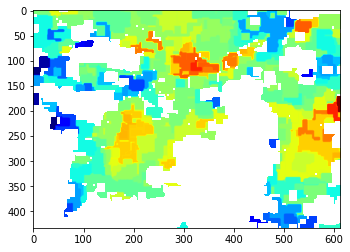

In [293]:
image_projected_bgr, image_projected = pollution3.load_image_from_files("proj-" + pollution3.get_image_name())
image_projected = np.where(image_projected == 255, 0, image_projected)
image_projected = cv2.morphologyEx(image_projected, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations = 1)
#image_projected = cv2.normalize(image_projected, np.ones((image_projected.shape[0], image_projected.shape[0])), 0, pollution.vmax, cv2.NORM_MINMAX )
image_projected_mask = ma.masked_values(image_projected, 0.)

f0, (ax0) = plt.subplots(1,1)
ax0.imshow(image_projected_mask,cmap="jet")

Total connected components 5198
props 5198
id [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212

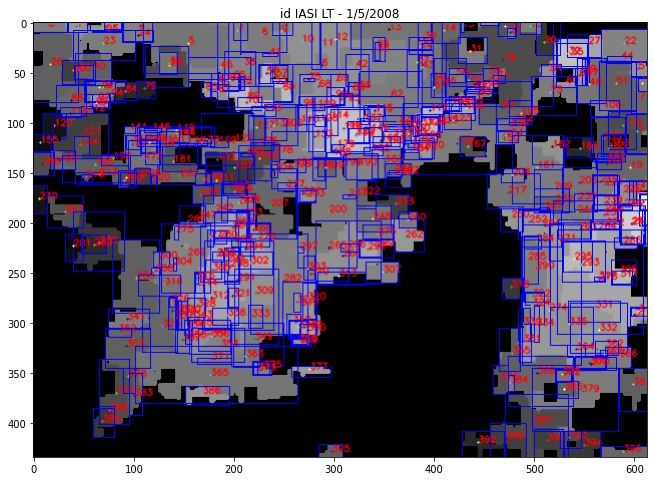

In [294]:
labels_cc, num_cc = pollution3.reconstruct_connected_component(image_projected_mask)
centroids, grays_values, areas_partition, boxes_partition, ids_valid_regions, coords_regions = pollution3.reconstruct_region_props(image_projected_mask, labels_cc)
pollution3.plot_regions_reconstructed(image_projected, centroids, areas_partition, grays_values,boxes_partition,ids_valid_regions,'id')

In [295]:
ids_to_render = [32, 35, 56, 99, 101, 104, 114, 117, 118, 124, 125, 128, 130, 131, 133, 134, 137, 139, 145, 148, 153, 165, 166, 188, 236, 240, 249, 256, 257, 264, 272, 279, 280, 293, 295, 298, 299, 301, 311, 317, 340]
#ids_to_render = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]


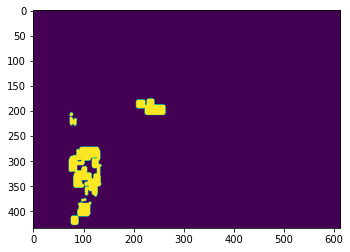

In [296]:
# quiero plotear solamente la region con el id 389
bl = np.zeros(image_projected.shape, np.uint8)
image_projected_mask2 = cv2.normalize(image_projected, np.ones((image_projected.shape[1], image_projected.shape[0])), pollution3.vmin, pollution3.vmax, cv2.NORM_MINMAX )

for id in ids_to_render:
  for i in range(len(ids_valid_regions)):
    if ids_valid_regions[i] == id:
      x_min,y_min, x_max,y_max = boxes_partition[i]
      longs = np.arange(x_min,x_max,1)
      lats = np.arange(y_min,y_max,1) # inverted min and max due errors in mapping
        
      set_of_coordinates = list()
      for lon in longs:
        for lat in lats:
          if np.isnan(lat):
            print("lat is nan")
          if np.isnan(lon):
            print("lon is nan")

          if image_projected_mask[int(lon), int(lat)] > 0 and image_projected_mask2[int(lon), int(lat)] == int(grays_values[i]):
            cv2.circle(bl, (int(lon),int(lat)), radius=3, color=255, thickness=-1)
            #bl[int(lon), int(lat)] = image_projected_mask[int(lon), int(lat)]

plt.imshow(bl)

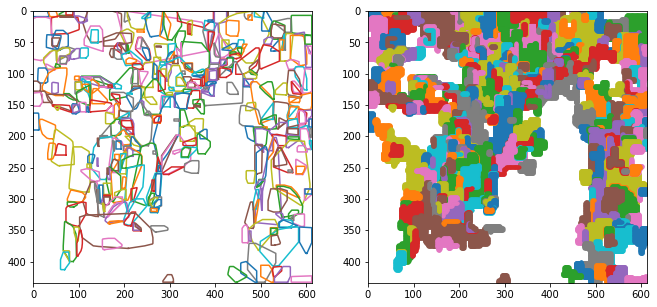

In [297]:
fig,(ax,ax2) = plt.subplots(1,2, figsize=(11,5))
for r in coords_regions[:]:
  
  caa = [c[0] for c in r]
  daa = [d[1] for d in r]
  region = list()
  hull = cv2.convexHull(r)
  box = cv2.boundingRect(r)

  for h in hull:
      region.append(h[0].tolist())

  region.append(region[0])
  poly = Polygon(region)
  line = LineString(region)
  x, y = line.xy
  
  ax.plot(y,x)
  ax2.scatter(daa,caa,marker='.')

  xrange1 = [0, image_projected_mask.shape[1]]
  yrange1 = [0, image_projected_mask.shape[0]]
  ax.set_xlim(*xrange1)
  ax.set_ylim(*yrange1)
  ax.invert_yaxis()
  ax2.set_xlim(*xrange1)
  ax2.set_ylim(*yrange1)
  ax2.invert_yaxis()



In [298]:
N_CLUSTERS = 5

X, weights = pollution3.create_X(image_projected,centroids,grays_values,WEIGHT)
cluster_labels, cluster_centers, model = pollution3.classify_regions(X,weights,N_CLUSTERS)
image_cluster = pollution3.get_image_cluster(image_projected,cluster_labels,boxes_partition,grays_values)

clustering...
Cluster finished.


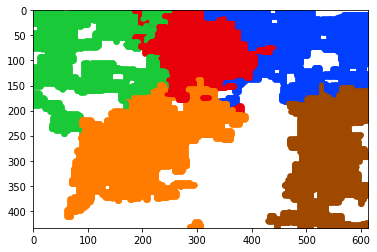

In [304]:
fig,ax = plt.subplots(1,1)

max_color_value = np.max(cluster_labels) + 1
colors = sns.color_palette("bright", max_color_value + 1)
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(np.arange(0, max_color_value + 1) - 0.5, cmap.N)

for i in range(len(cluster_labels)):
  y = [pnt[0] for pnt in coords_regions[i]]
  x = [pnt[1] for pnt in coords_regions[i]]
  ax.scatter(x,y,marker='.', color=cmap(norm(int(cluster_labels[i]))))
  xrange1 = [0, image_projected_mask.shape[1]]
  yrange1 = [0, image_projected_mask.shape[0]]
  ax.set_xlim(*xrange1)
  ax.set_ylim(*yrange1)
  ax.invert_yaxis()

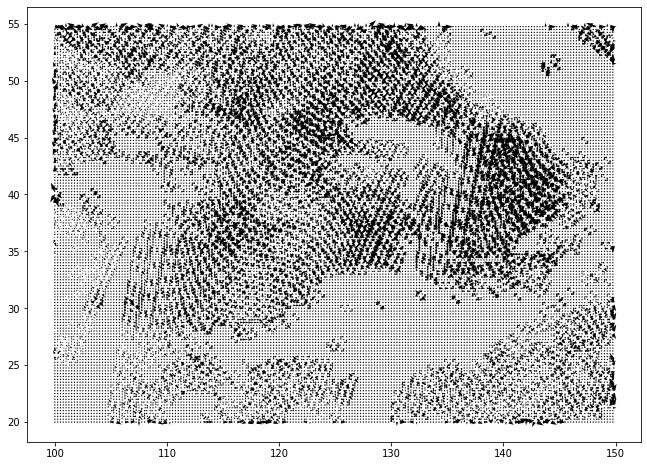

In [ ]:
gradx, grady = np.gradient (pollution3.colgrid, edge_order=1)
v_x, v_y = np.meshgrid(pollution.lon_g, pollution.lat_g)

gradx1, grady1 = np.gradient (image_projected_mask, edge_order=1)
v_x1, v_y1= np.meshgrid(np.arange(image_projected_mask.shape[1]), np.arange(image_projected_mask.shape[0]))

fig, ax = plt.subplots(1,1, figsize=(11,8))
#ax.contour(v_x1, v_y1, image_projected_mask, levels=5, colors = 'k', linewidths = 1, linestyles = 'solid' )
ax.quiver(v_x, v_y, gradx,grady)

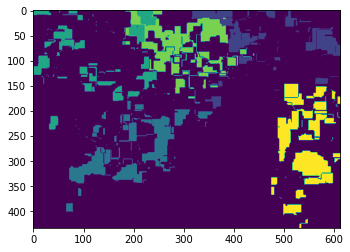

In [178]:
plt.imshow(image_cluster)

finding best cluster...


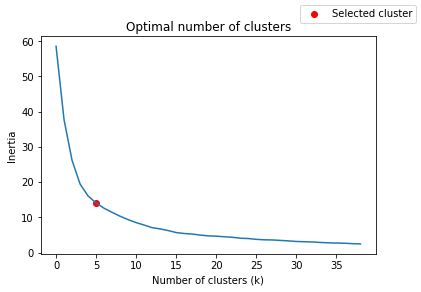

In [76]:
pollution3.plot_test_best_cluster_number(X,weights,40,N_CLUSTERS)

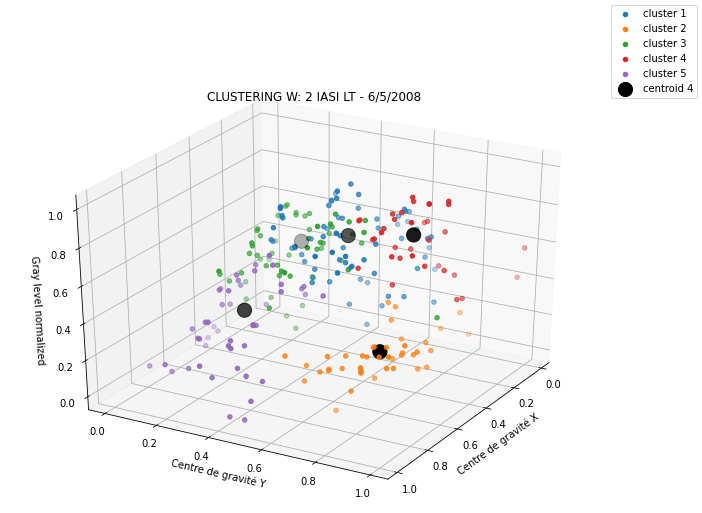

In [ ]:
pollution.plot_clustered_regions_3d(X,WEIGHT,cluster_labels,cluster_centers)

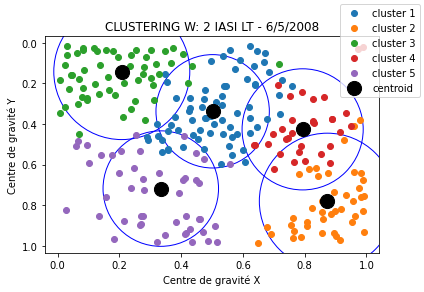

In [ ]:
pollution.plot_clustered_regions_2d(X,WEIGHT, cluster_labels, cluster_centers)

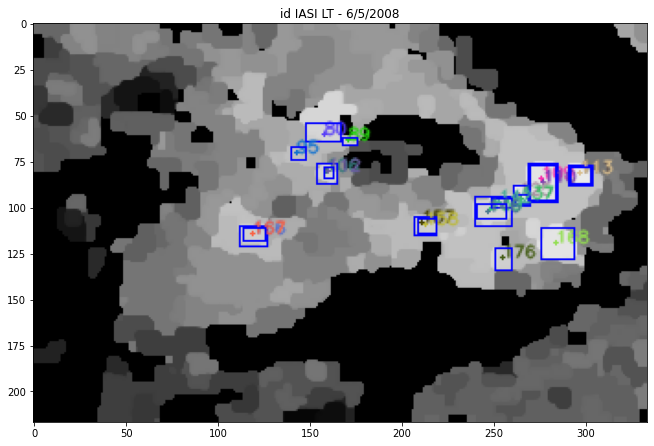

In [ ]:
pollution.plot_regions_reconstructed(image_projected, centroids, areas_partition, grays_values,boxes_partition,'id', 31)

Text(0, 0.5, '$y$')

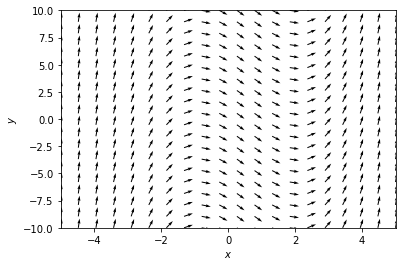

In [ ]:
from scipy.integrate import odeint

fig = plt.figure()

def vf(x, t):
    dx = np.zeros(2)
    dx[0] = 1.0
    dx[1] = x[0] ** 2 - x[0] - 2.0
    return dx

# Solution curves
t0 = 0.0
tEnd = 10.0

# Vector field
X, Y = np.meshgrid(np.linspace(-5, 5, 20), np.linspace(-10, 10, 20))
U = 1.0
V = X ** 2 - X - 2
# Normalize arrows
N = np.sqrt(U ** 2 + V ** 2)
U = U / N
V = V / N
plt.quiver(X, Y, U, V, angles="xy")

#t = np.linspace(t0, tEnd, 100)
#for y0 in np.linspace(-5.0, 0.0, 10):
#    y_initial = [y0, -10.0]
#    y = odeint(vf, y_initial, t)
#    plt.plot(y[:, 0], y[:, 1], "-")

plt.xlim([-5, 5])
plt.ylim([-10, 10])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

In [133]:
def get_clusters_days(year,month,day,image_type,vmax,N_CLUSTERS=5):
  WEIGHT = 2

  pollution = PollutionTracker()
  pollution.set_year(year)
  pollution.set_month(month)
  pollution.set_day(day)
  pollution.set_image_type(image_type)
  pollution.set_vmin(10)
  pollution.set_vmax(vmax)
  pollution.set_image_name("levels")
  pollution.set_weight_gray_values(1)
  pollution.set_cluster_value(30)
  pollution.set_pixel_size(0.25,.125)
  pollution.get_image_by_leves()
  image_bgr , image_gray = pollution.load_image_from_files(pollution.get_image_name())
  image, foreground, background = pollution.filter_image(image_gray)
  image,image_rbg,image_masked = pollution.filter_image_for_mser(image,foreground)
  regions_mser, boxes_mser = pollution.get_mser_regions(image_rbg)
  regx, regy, regs, polys, lines, values = pollution.set_mser_regions(image_masked, regions_mser)
  pollution.create_label(image_masked,regx, regy, values)

  
  _, image_projected = pollution.load_image_from_files("proj-" + pollution.get_image_name())
  image_projected = np.where(image_projected == 255, 0, image_projected)
  image_projected = cv2.morphologyEx(image_projected, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations = 1)
  image_projected_mask = ma.masked_values(image_projected, 0.)

  #fig_, ax0 = plt.subplots(1,1, figsize=(11,8))
  #ax0.imshow(image_projected_mask,cmap="jet")
  #ax0.axis('off')
  #fig_.savefig("/content/drive/MyDrive/LIPADE/Smooth/proj-" + pollution.image_name, bbox_inches='tight', pad_inches=0)
  #plt.close(fig_)

  labels_cc, num_cc = pollution.reconstruct_connected_component(image_projected_mask)
  centroids, grays_values, areas_partition, boxes_partition, ids_valid_regions = pollution.reconstruct_region_props(image_projected_mask, labels_cc)

  X, weights = pollution.create_X(image_projected,centroids,grays_values,WEIGHT)
  cluster_labels, cluster_centers, model = pollution.classify_regions(X,weights,N_CLUSTERS)
  image_cluster = pollution.get_image_cluster(image_projected,cluster_labels,boxes_partition)

  #pollution.export_points_cluster_image(X,cluster_labels, cluster_centers)
  #pollution.plot_regions_reconstructed(image_projected, centroids, areas_partition, grays_values,boxes_partition,ids_valid_regions,'id')
  #pollution.plot_test_best_cluster_number(X,weights,40,N_CLUSTERS)
  #pollution.plot_clustered_regions_3d(X,WEIGHT,cluster_labels,cluster_centers)
  #pollution.plot_clustered_regions_2d(X,WEIGHT, cluster_labels, cluster_centers)

  return X,cluster_labels,cluster_centers,weights,image_cluster,grays_values,centroids,foreground,image_masked
  #return 1,2,3,4,5,6,7,8,9
  #return centroids, grays_values, boxes_partition, ids_valid_regions

In [134]:
all_input_lt = list()
all_input_ut = list()

all_labels_lt = list()
all_labels_ut = list()

all_centers_lt = list()
all_centers_ut = list()

all_weights_lt = list()
all_weights_ut = list()

all_images_cluster_lt = list()
all_images_cluster_ut = list()

all_grays_vals_lt = list()
all_grays_vals_ut = list()

all_centroids_vals_lt = list()
all_centroids_vals_ut = list()

all_foreground_lt = list()
all_foreground_ut = list()

all_masks_lt = list()
all_masks_ut = list()

for i in range(1,3):

  print(str(i) + "---------------------------------------------------------------------------")
  #if i == 10 or i == 11 or i == 12:
  #  continue
  
  X_lt, labels_lt, centers_lt , weights_lt, image_cluster_lt, gray_val_lt, centroid_val_lt, foreground_lt, mask_lt = get_clusters_days(2008,5,i,"LT",35,5)
  X_ut, labels_ut, centers_ut , weights_ut, image_cluster_ut, gray_val_ut, centroid_val_ut, foreground_ut, mask_ut = get_clusters_days(2008,5,i,"UT",45,5)
  all_input_lt.append(X_lt)
  all_input_ut.append(X_ut)
  all_labels_lt.append(labels_lt)
  all_labels_ut.append(labels_ut)
  all_centers_lt.append(centers_lt)
  all_centers_ut.append(centers_ut)
  all_weights_lt.append(weights_lt)
  all_weights_ut.append(weights_ut)
  all_images_cluster_lt.append(image_cluster_lt)
  all_images_cluster_ut.append(image_cluster_ut)
  all_grays_vals_lt.append(gray_val_lt)
  all_grays_vals_ut.append(gray_val_ut)
  all_centroids_vals_lt.append(centroid_val_lt)
  all_centroids_vals_ut.append(centroid_val_ut)
  all_foreground_lt.append(foreground_lt)
  all_foreground_ut.append(foreground_ut)
  all_masks_lt.append(mask_lt)
  all_masks_ut.append(mask_ut)

1---------------------------------------------------------------------------
reading info ...
data have been read correctly
REGIONS found with MSER 491
Class finished
Total connected components 5198
props 5198
clustering...
Cluster finished.
Class finished
reading info ...
data have been read correctly
REGIONS found with MSER 71
Total connected components 1832
props 1832
clustering...
Cluster finished.
Class finished
2---------------------------------------------------------------------------
reading info ...
data have been read correctly
REGIONS found with MSER 338
Total connected components 3261
props 3261
clustering...
Cluster finished.
Class finished
reading info ...
data have been read correctly
REGIONS found with MSER 67
Total connected components 1405
props 1405
clustering...
Cluster finished.
Class finished


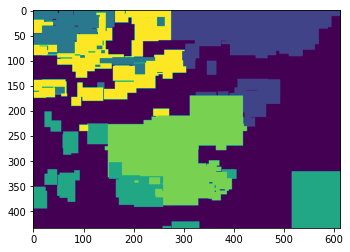

In [136]:
plt.imshow(all_images_cluster_lt[1])

In [ ]:
## CREATE VIDEO FROM IMAGES

image_folder = '/content/drive/MyDrive/LIPADE/Cluster/'
video_name = 'video-cluster2.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images[:]:
    video.write(cv2.imread(os.path.join(image_folder, image)))

#cv2.destroyAllWindows()
video.release()

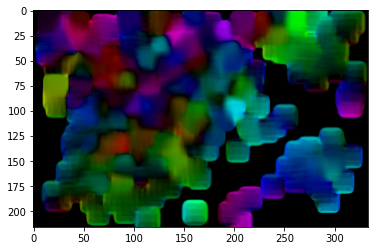

In [ ]:
# Capturing the video file 0 for videocam else you can provide the url
capture = cv2.VideoCapture(video_name)
  
# Reading the first frame
_, frame1 = capture.read()
# Convert to gray scale
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
# Create mask
hsv_mask = np.zeros_like(frame1)
# Make image saturation to a maximum value
hsv_mask[..., 1] = 255

juli = 0

# Till you scan the video
while(juli < len(images[:]) - 1):
  juli += 1
  # Capture another frame and convert to gray scale
  _, frame2 = capture.read()
  next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

  # Optical flow is now calculated
  flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
  # Compute magnite and angle of 2D vector
  mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
  # Set image hue value according to the angle of optical flow
  hsv_mask[..., 0] = ang * 180 / np.pi / 2
  # Set value as per the normalized magnitude of optical flow
  hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
  # Convert to rgb
  rgb_representation = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)

  plt.imshow(rgb_representation)
  prvs = next

capture.release()

In [ ]:

for iii in range(2, 31):
  cap = cv2.VideoCapture(video_name)

  # params for corner detection
  feature_params = dict( maxCorners = 100,
                        qualityLevel = 0.03,
                        minDistance = 10,
                        blockSize = 7 )
    
  # Parameters for lucas kanade optical flow
  lk_params = dict( winSize = (25, 25),
                    maxLevel = 3,
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,10, 0.03))
    
  # Create some random colors
  color = np.random.randint(0, 255, (100, 3))

  # Take first frame and find corners in it
  ret, old_frame = cap.read()

  if old_frame is None:
    print("Not data")

  old_gray = cv2.cvtColor(old_frame,cv2.COLOR_RGB2GRAY)
  p0 = cv2.goodFeaturesToTrack(old_gray, mask = None,
                              **feature_params)
  first_good_old = None
  p_i_x, p_i_y = None,None
  p_f_x, p_f_y = None,None

  # Create a mask image for drawing purposes
  mask = np.zeros_like(old_frame)

  fig, (ax1) = plt.subplots(1,1, figsize=(11,8))

  for ii in range(len(images[:iii]) - 1):

    ret, frame = cap.read()
    frame_gray = cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray,frame_gray, p0, None, **lk_params)
    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
      a, b = new.ravel()
      c, d = old.ravel()

      # color[i].tolist()
      mask = cv2.line(mask, (a, b), (c, d), [40,40,40] , 1)
      #mask = cv2.circle(mask, (a, b), 1, [255,0,0], -1)

      if ii == 0:
        p_i_x = c
        p_i_y = d
        mask = cv2.circle(mask, (c, d), 1, [255,0,0], -1)

      if ii == len(images[:(iii - 1)]) - 1:
        p_f_x = a
        p_f_y = b
        mask = cv2.circle(mask, (a, b), 1, [0,0,255], -1)

      #if p_i_x is not None and p_i_y is not None and p_f_x is not None and p_f_y is not None:
        #mask = cv2.line(mask, (p_f_x, p_f_y), (p_i_x, p_i_y), [255,255,255] , 1)
  
    #img = cv2.add(frame, mask)
    ax1.imshow(mask)
    
    # Updating Previous frame and points 
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

  fig.savefig("/content/drive/MyDrive/LIPADE/LK/lines/ln-lt052008-" + str(iii - 1) + ".png", bbox_inches='tight', pad_inches=0)
  plt.close(fig)

  cap.release()



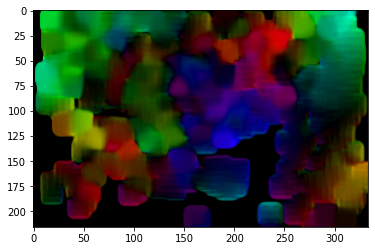

In [ ]:
# The video feed is read in as
# a VideoCapture object
cap = cv2.VideoCapture(video_name)
  
# ret = a boolean return value from
# getting the frame, first_frame = the
# first frame in the entire video sequence
ret, first_frame = cap.read()
  
# Converts frame to grayscale because we
# only need the luminance channel for
# detecting edges - less computationally 
# expensive
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
  
# Creates an image filled with zero
# intensities with the same dimensions 
# as the frame
mask = np.zeros_like(first_frame)
  
# Sets image saturation to maximum
mask[..., 1] = 255

juli = 0

while(juli < len(images[:2]) - 1):
    juli += 1
    # ret = a boolean return value from getting
    # the frame, frame = the current frame being
    # projected in the video
    ret, frame = cap.read()
  
    # Converts each frame to grayscale - we previously 
    # only converted the first frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      
    # Calculates dense optical flow by Farneback method
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, 
                                       None,
                                       0.5, 3, 15, 3, 5, 1.2, 0)
      
    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
      
    # Sets image hue according to the optical flow 
    # direction
    mask[..., 0] = angle * 180 / np.pi / 2
      
    # Sets image value according to the optical flow
    # magnitude (normalized)
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
      
    # Converts HSV to RGB (BGR) color representation
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
      
    # Opens a new window and displays the output frame
    plt.imshow(rgb)
      
    # Updates previous frame
    prev_gray = gray
    
# The following frees up resources and
# closes all windows
cap.release()

In [ ]:

# Obtiene los clusters mas elevados segun indice. i.e quiero el primero, o el segundo mas elevado, o el tercero etc..
def get_arg_max(centers_z, index):
  centers = centers_z.copy()
  if index == 1 or index == 0:
    return np.argmax(centers)
  else:
    for i in range(index - 1):
      centers[np.argmax(centers)] = 0
    return np.argmax(centers)

#print(get_arg_max(cluster_centers[2][:,2], 1))
#print(get_arg_max(cluster_centers[2][:,2], 2))
#print(get_arg_max(cluster_centers[2][:,2], 3))
#print(get_arg_max(cluster_centers[2][:,2], 4))

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity

def get_next_similar_cluster(current_cluster, next_day_clusters, day_after_tomorrow_clusters):
  current = current_cluster.copy()
  current = np.array([current])
  nexts = next_day_clusters.copy()
  nexts = np.array(nexts)
  lasts = day_after_tomorrow_clusters.copy()
  lasts = np.array(lasts)
  
  #last with current
  highest_last_cluster = lasts[get_arg_max(lasts[:,2], 1)]
  second_highest_last_cluster = lasts[get_arg_max(lasts[:,2], 2)]
  dist_to_last = cdist(lasts,current, 'mahalanobis', VI=None)
  closest_cluster = lasts[np.argmin(dist_to_last)]
  cos_sim_last = cosine_similarity(lasts,current)
  most_similar_cluster_last = np.array([lasts[np.argmax(cos_sim_last)]])

  #last with midd
  highest_mid_cluster = nexts[get_arg_max(nexts[:,2], 1)]
  second_highest_mid_cluster = nexts[get_arg_max(nexts[:,2], 2)]
  cos_sim_mid = cosine_similarity(nexts,most_similar_cluster_last)
  dist_to_mid = cdist(nexts,most_similar_cluster_last, 'mahalanobis', VI=None)
  most_similar_cluster_mid = np.array([nexts[np.argmax(cos_sim_mid)]])
  closest_cluster_mid = nexts[np.argmin(dist_to_mid)]


  mid_c = most_similar_cluster_mid.reshape(3,)
  last_c = most_similar_cluster_last.reshape(3,)
  cur_c = current.reshape(3,)
  v_norm = np.sqrt(sum(last_c**2))
  proj_of_u_on_v = (np.dot(cur_c, last_c)/v_norm**2)*last_c

 

  #print("--")
  #print(current)
  #print(lasts)
  print(proj_of_u_on_v)
  #print("high",highest_last_cluster)
  #print("2ndhigh", second_highest_last_cluster)
  #print("close",closest_cluster)
  #print("simil", most_similar_cluster_last)
  #print("\n")
  #print(nexts)
  #print(most_similar_cluster_mid)
  #print(closest_cluster_mid)
  #print(highest_mid_cluster)
  #print(second_highest_mid_cluster)

  return [current, most_similar_cluster_mid, most_similar_cluster_last]



  #for last in lasts:
    #print(current, last)
    #dist_to_last = cdist(current, last, 'mahalanobis', VI=None)
    #print(dist_to_last)
    


current_day_cluster = 1

current_cluster = all_centers_lt[current_day_cluster].copy()
current_cluster = current_cluster[get_arg_max(current_cluster[:,2], 2)]
next_day_clusters = all_centers_lt[current_day_cluster + 1].copy()
day_after_tomorrow_clusters = all_centers_lt[current_day_cluster + 2].copy()

a = get_next_similar_cluster(current_cluster, next_day_clusters, day_after_tomorrow_clusters)  


[0.22224702 0.7396153  0.52596701]


[0.24384134 0.35546099 0.78843751]


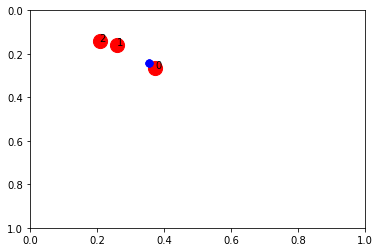

In [ ]:
current_day_cluster = 3

current_cluster = all_centers_lt[current_day_cluster].copy()
current_cluster = current_cluster[get_arg_max(current_cluster[:,2], 1)]
next_day_clusters = all_centers_lt[current_day_cluster + 1].copy()
day_after_tomorrow_clusters = all_centers_lt[current_day_cluster + 2].copy()

cluster_centers = get_next_similar_cluster(current_cluster, next_day_clusters, day_after_tomorrow_clusters)  

fig, ax = plt.subplots(1,1)
for i in range(len(cluster_centers)):
  c = "red"
  ax.text(cluster_centers[i][:,1][0], cluster_centers[i][:,0][0], str(i))
  ax.scatter(cluster_centers[i][:,1],cluster_centers[i][:,0],s=200,c=c)
  ax.scatter([0.355],[0.243],s=50,c="b") # 1
  # ax.scatter([0.721],[0.388],s=50,c="b") # 2
  # ax.scatter([0.814],[0.727],s=50,c="b") # 3
  # ax.scatter([0.225],[0.154],s=50,c="b") # 4

ax.set_xlim([0,1])
ax.set_ylim([1,0])
fig.show()

0
2


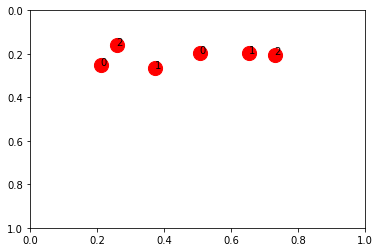

In [ ]:
fig, ax = plt.subplots(1,1)

for i in range(0, len(all_centers_lt) - 2, 2):
  print(i)
  current_day_cluster = i

  current_cluster = all_centers_lt[current_day_cluster].copy()
  current_cluster = current_cluster[get_arg_max(current_cluster[:,2], 1)]
  next_day_clusters = all_centers_lt[current_day_cluster + 1].copy()
  day_after_tomorrow_clusters = all_centers_lt[current_day_cluster + 2].copy()

  cluster_centers = get_next_similar_cluster(current_cluster, next_day_clusters, day_after_tomorrow_clusters)  
  
  for i in range(len(cluster_centers)):
    c = "red"
    ax.text(cluster_centers[i][:,1][0], cluster_centers[i][:,0][0], str(i))
    ax.scatter(cluster_centers[i][:,1],cluster_centers[i][:,0],s=200,c=c)

  ax.set_xlim([0,1])
  ax.set_ylim([1,0])
  fig.show()

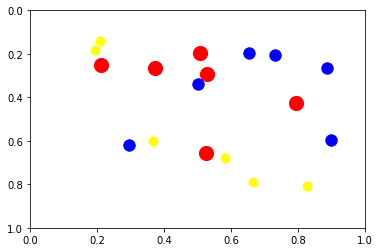

In [ ]:
cluster_centers = all_centers_lt.copy()

fig, ax = plt.subplots(1,1)
for i in range(len(all_centers_lt)):
  c = "red"
  ax.scatter(cluster_centers[i][:,1][get_arg_max(cluster_centers[i][:,2], 1)],cluster_centers[i][:,0][get_arg_max(cluster_centers[i][:,2], 1)],s=200,c=c)

for i in range(len(all_centers_lt)):
  c = "blue"
  ax.scatter(cluster_centers[i][:,1][get_arg_max(cluster_centers[i][:,2], 2)],cluster_centers[i][:,0][get_arg_max(cluster_centers[i][:,2], 2)],s=130,c=c)

for i in range(len(all_centers_lt)):
  c = "yellow"
  ax.scatter(cluster_centers[i][:,1][get_arg_max(cluster_centers[i][:,2], 3)],cluster_centers[i][:,0][get_arg_max(cluster_centers[i][:,2], 3)],s=80,c=c)

ax.set_xlim([0,1])
ax.set_ylim([1,0])
fig.show()

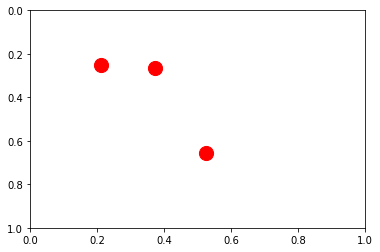

In [ ]:
cluster_centers = all_centers_lt.copy()

fig, ax = plt.subplots(1,1)
for i in range(1,4):
  c = "red"
  ax.scatter(cluster_centers[i][:,1][get_arg_max(cluster_centers[i][:,2], 1)],cluster_centers[i][:,0][get_arg_max(cluster_centers[i][:,2], 1)],s=200,c=c)

ax.set_xlim([0,1])
ax.set_ylim([1,0])
fig.show()

In [ ]:
test_i_lt = all_input_lt.copy()
test_l_lt = all_labels_lt.copy()
test_w_lt = all_weights_lt.copy()

export_input_lt_x = ['X_m']
export_input_lt_y = ['Y_m']
export_input_lt_z = ['Z_m']
export_label_lt = ['label']
export_weight_lt = ['w']
export_day_lt = ['day']
export_du_lt = ['DU']
export_center_lt = ['centroid']

for i in range(len(test_i_lt)):
  
  for c in test_i_lt[i][:,0]:
    export_input_lt_x.append(c)
    # append the day also
    export_day_lt.append((i+1))
  
  for c in test_i_lt[i][:,1]:
    export_input_lt_y.append(c)
  
  for c in test_i_lt[i][:,2]:
    export_input_lt_z.append(c)

  for l in test_l_lt[i]:
    export_label_lt.append(l)

  for w in test_w_lt[i]:
    export_weight_lt.append(w)

  for du in all_grays_vals_lt[i]:
    export_du_lt.append(w)

  for c in all_centroids_vals_lt[i]:
    export_center_lt.append(c)

np.savetxt('export_llt.csv', [p for p in zip(export_input_lt_x, 
                                            export_input_lt_y,
                                            export_input_lt_z,
                                            export_label_lt,
                                            export_weight_lt,
                                            export_day_lt,
                                            export_du_lt)], delimiter=',', fmt='%s')

In [ ]:
test_c_lt = all_centers_lt.copy()

export_centers_lt_x = ['center_x']
export_centers_lt_y = ['center_y']
export_centers_lt_z = ['center_z']
export_day_c = ['day']

for i in range(len(test_c_lt)):
  for c in test_c_lt[i][:,0]:
    export_centers_lt_x.append(c)
    # append the day also
    export_day_c.append((i+1))
  for c in test_c_lt[i][:,1]:
    export_centers_lt_y.append(c)
  for c in test_c_lt[i][:,2]:
    export_centers_lt_z.append(c)

np.savetxt('export_centers_llt.csv', [p for p in zip(export_centers_lt_x, export_centers_lt_y,export_centers_lt_z,export_day_c)], delimiter=',', fmt='%s')

In [11]:
def get_region_value2(image, polygon, foreground, vmin=10, vmax=45):
    """
    This function returns the mean pixel value from a given polygon
    """

    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , vmin, vmax, cv2.NORM_MINMAX )
    image = cv2.bitwise_and(image,image, mask=foreground)

    x,y,w,h = polygon
    longs = np.arange(x, (x+w), 1)
    lats = np.arange(y, (y+h), 1) # inverted min and max due errors in mapping

    set_of_coordinates = list()
    for lon in longs:
      for lat in lats:
        if np.isnan(lat):
          print("lat is nan")
        if np.isnan(lon):
          print("lon is nan")

        if image[int(lat), int(lon)] > 0:
          set_of_coordinates.append(image[int(lat), int(lon)])

    value_pixel = np.mean(set_of_coordinates)

    if np.isnan(value_pixel):
      value_pixel = 1.
    
    return value_pixel

In [12]:
def get_image_from_seuil (image_cluster, image_masked, foreground, seuil = 0):
  im_acum = np.zeros(image_cluster.shape, np.uint8)

  for cl in range(1,11):
    im_orig = np.zeros(image_cluster.shape, np.uint8)
    im_orig = np.where(image_cluster == cl,1, im_orig)
    contours_orig, _ = cv2.findContours(im_orig, 1, 2)

    for i,cnt in enumerate(contours_orig):
      box = cv2.boundingRect(cnt)
      x,y,w,h = box
      
      if ( w*h ) > 1000:
        g = get_region_value2(image_masked,box,foreground)
        im_acum = np.where(image_cluster == cl, g, im_acum)
        im_orig = np.where(image_cluster == cl,g, im_orig)

    im_acum = np.where(im_acum < seuil, 0, im_acum)

  return im_acum

In [16]:
def compare_clusters_individually(foregrounds, masks, clusters, labels, image_type="LT", year=2008, month=5):
  directories = os.listdir( DIR_TRAIN )
  container_labels_days = list()

  for day in range(1,len(foregrounds) + 1):
    foreground = foregrounds[day - 1]
    image_masked = masks[day - 1]
    image_cluster = clusters[day - 1]
    cluster_labels = labels[day - 1]

    # Check for December
    if month == 12:
      if day == 10 or day == 11 or day == 12:
        print("This day there is not observation")
        continue

    # This would print all the files and directories
    for file in directories:
      only_png_files = re.search(".jpg", file)
      if only_png_files is not None:
        only_same_day = re.search(str(year)+"%02d"%month+"%02d"%day, file)
        if only_same_day is not None:
          only_image_type = re.search(image_type, file)
          if only_image_type is not None:
            img = io.imread(DIR_TRAIN + file)
            img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img_gray = cv2.GaussianBlur(img_gray,(5,5),cv2.BORDER_DEFAULT)

            labels_day = np.zeros([max(cluster_labels) + 1], np.uint8)

            for i in range(1,max(cluster_labels) + 1):
              im_bin = img_gray.copy()
              
              im_orig = np.zeros(image_cluster.shape, np.uint8)
              im_orig = np.where(image_cluster == i,1, im_orig)

              im_bin = cv2.normalize(im_bin, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
              im_orig = cv2.normalize(im_orig, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
              
              total_pixels_blancs_ref = len(im_bin[im_bin != 0])
              total_pixels_blancs_test = len(im_orig[im_orig != 0])

              if total_pixels_blancs_test == 0:
                break

              im_orig = np.where(im_orig != 0, 1, im_orig)
              c_m_temp = confusion_matrix(im_bin.flatten(), im_orig.flatten())
              true_positives = c_m_temp[1][1]

              perc_t_p = true_positives * 100 / total_pixels_blancs_test

              if perc_t_p > 50:
                labels_day[i] = 1
                #print("---------------> i", i)
                #plt.figure()
                #plt.title("Ground Truth and Regions "+str(day)+"/5/2008 cluster")
                #plt.imshow(np.dstack((np.int_(im_orig), im_bin, im_bin))*255)
                #plt.show()

            container_labels_days.append(labels_day)
  return container_labels_days

In [17]:
def compare_with_ground_truth(foregrounds, masks, clusters, year=2008, month=5, image_type="LT", plot=False, max_range=35):
  directories = os.listdir( DIR_TRAIN )
  container_f_p = list()
  container_f_n = list()

  for day in range(1,len(foregrounds) + 1):
    foreground = foregrounds[day - 1]
    image_masked = masks[day - 1]
    image_cluster = clusters[day - 1]

    # Check for December
    if month == 12:
      if day == 10 or day == 11 or day == 12:
        print("This day there is not observation")
        continue

    # This would print all the files and directories
    for file in directories:
      only_png_files = re.search(".jpg", file)
      if only_png_files is not None:
        only_same_day = re.search(str(year)+"%02d"%month+"%02d"%day, file)
        if only_same_day is not None:
          only_image_type = re.search(image_type, file)
          if only_image_type is not None:
            img = io.imread(DIR_TRAIN + file)
            img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img_gray = cv2.GaussianBlur(img_gray,(5,5),cv2.BORDER_DEFAULT)

            all_true_positives_c = list()
            all_false_positives_c = list()
            all_false_negatives_c = list()

            if image_type == "UT":
              max_range = 45
            
            for t in range(10,max_range,2):
              im_orig = get_image_from_seuil(image_cluster, image_masked, foreground,t)
              im_bin = img_gray.copy()

              total_pixels_blancs_ref = len(im_bin[im_bin != 0])
              total_pixels_blancs_test = len(im_orig[im_orig != 0])

              if total_pixels_blancs_test == 0:
                break

              im_orig = np.where(im_orig != 0, 1, im_orig)
              c_m_temp = confusion_matrix(im_bin.flatten(), im_orig.flatten())
              true_positives = c_m_temp[1][1]
              false_positives = c_m_temp[0][1]
              false_negatives = c_m_temp[1][0]
              true_negatives = c_m_temp[0][0]

              perc_t_p = true_positives * 100 / total_pixels_blancs_test

              #if perc_t_p > 0:
              all_true_positives_c.append(true_positives * 100 / total_pixels_blancs_test)
              all_false_positives_c.append(false_positives * 100 / total_pixels_blancs_test)
              all_false_negatives_c.append(false_negatives * 100 / total_pixels_blancs_ref)
              
              if plot == True:
                plt.figure()
                plt.title("Ground Truth and Regions "+str(day)+"/5/2008 cluster at DU=" + str(t) )
                plt.imshow(np.dstack((np.int_(im_orig), im_bin, im_bin))*255)
                plt.show()
            
            container_f_p.append(all_false_positives_c)
            container_f_n.append(all_false_negatives_c)

  return container_f_p, container_f_n

In [18]:
def assign_cluster_target_to_regions(labels,clusters_target):
  all_regions_target = list()

  for day in range(1,len(labels) + 1):
    labels_day = labels[day - 1]
    clusters_day = clusters_target[day - 1]
    regions_target = np.zeros([len(labels_day)], np.uint8)

    for i in range(len(clusters_day)):
      for j, label in enumerate(labels_day):
        if label == i:
          regions_target[j] = clusters_day[i]
      
    all_regions_target.append(regions_target)
    
  return all_regions_target

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


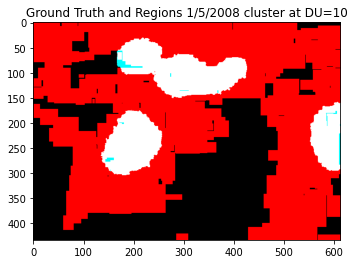

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


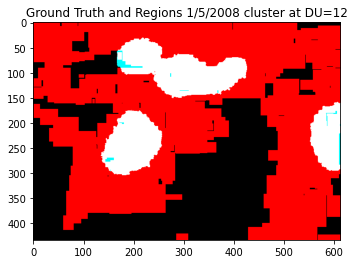

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


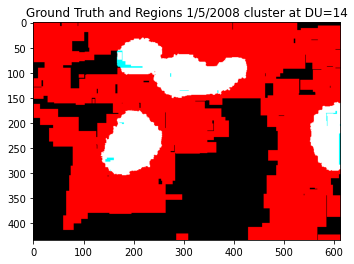

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


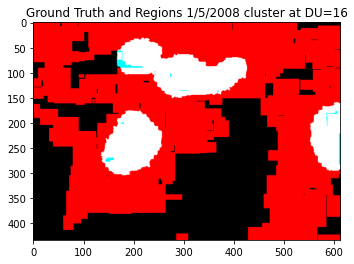

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


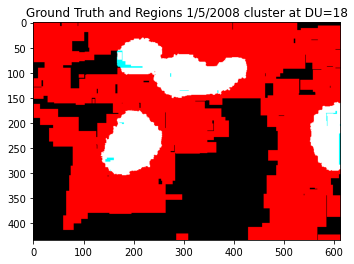

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


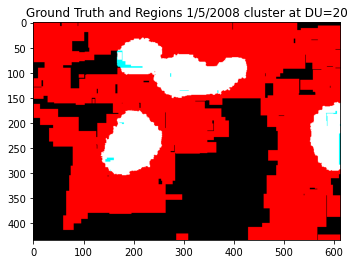

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


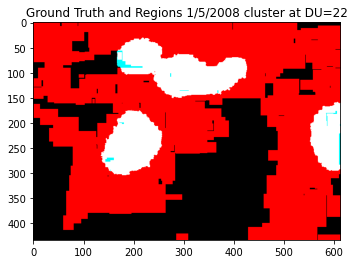

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


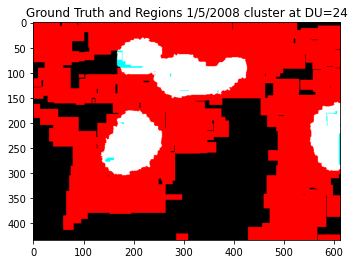

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


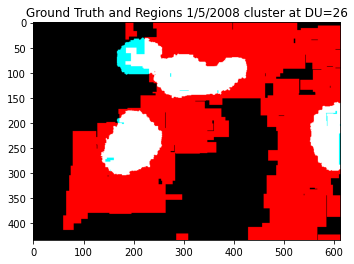

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


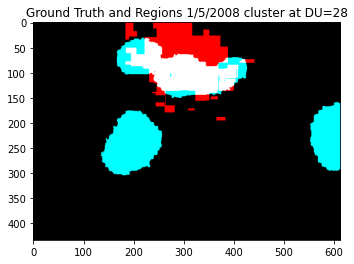

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


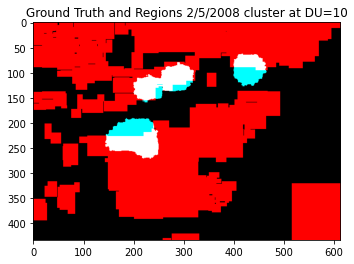

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


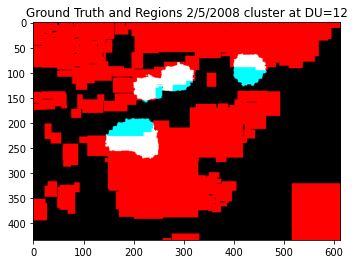

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


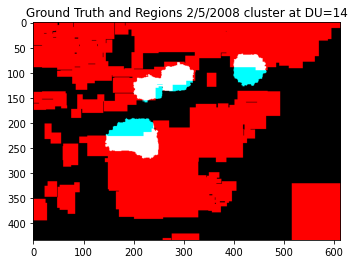

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


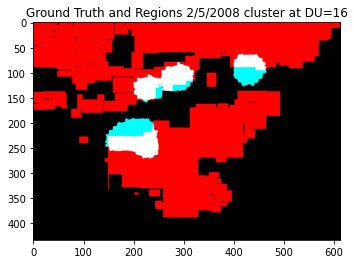

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


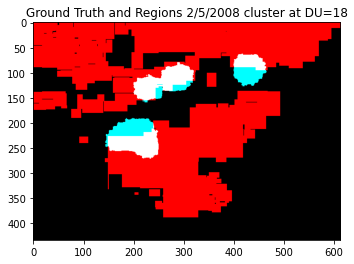

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


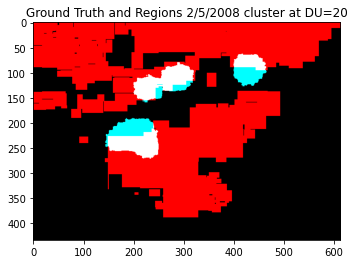

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


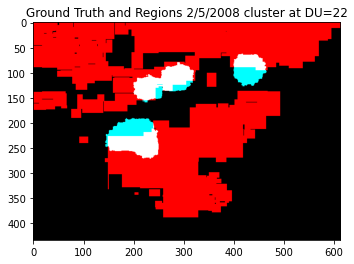

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


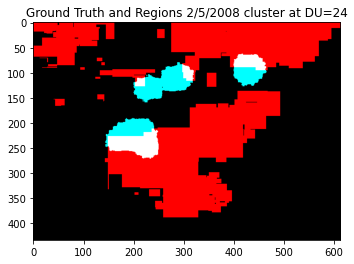

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


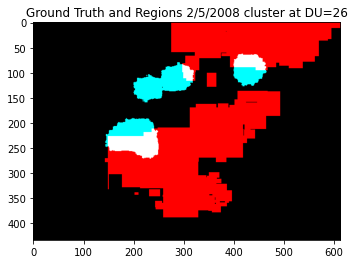

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


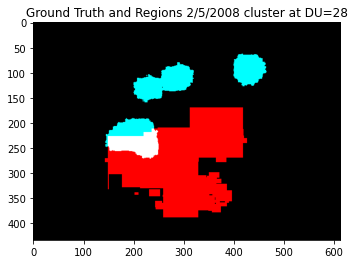

([[81.65237818197785,
   81.65237818197785,
   81.65237818197785,
   81.65237818197785,
   81.65237818197785,
   81.65237818197785,
   81.65237818197785,
   81.65237818197785,
   78.68425703138806,
   46.01560143084946],
  [92.6977400076104,
   92.6977400076104,
   92.6977400076104,
   91.03313119361042,
   91.03313119361042,
   91.03313119361042,
   91.03313119361042,
   92.5983695453493,
   91.8510043224002,
   90.29171894604768]],
 [[0.1222387147472278,
   0.1222387147472278,
   0.1222387147472278,
   0.1222387147472278,
   0.1222387147472278,
   0.1222387147472278,
   0.1222387147472278,
   0.1222387147472278,
   0.7799994179108821,
   4.959399284030385],
  [3.831261463215814,
   3.831261463215814,
   3.831261463215814,
   4.245635486719652,
   4.245635486719652,
   4.245635486719652,
   4.245635486719652,
   6.602812308946403,
   6.969635214998981,
   8.844507845934379]])

In [137]:
# to visualize
#compare_with_ground_truth(all_foreground_ut[:2], all_masks_ut[:2], all_images_cluster_ut[:2], 2008, 5, "UT",True)
compare_with_ground_truth(all_foreground_lt[:2], all_masks_lt[:2], all_images_cluster_lt[:2], 2008, 5, "LT",True)

In [138]:
clusters_target_lt = compare_clusters_individually(all_foreground_lt,all_masks_lt,all_images_cluster_lt, all_labels_lt)
clusters_target_ut = compare_clusters_individually(all_foreground_ut,all_masks_ut,all_images_cluster_ut, all_labels_ut)

In [139]:
all_regions_target_lt = assign_cluster_target_to_regions(all_labels_lt,clusters_target_lt)
all_regions_target_ut = assign_cluster_target_to_regions(all_labels_ut,clusters_target_ut)

In [140]:
lt_fp, lt_fn = compare_with_ground_truth(all_foreground_lt, all_masks_lt, all_images_cluster_lt, 2008, 5, "LT")

In [141]:
ut_fp, ut_fn = compare_with_ground_truth(all_foreground_ut, all_masks_ut, all_images_cluster_ut, 2008, 5, "UT")

In [36]:
def get_best_DU(falses_positives, falses_negatives, image_type, max_range=35):

  if image_type == "UT":
    max_range = 45

  list_du_test = np.arange(10, max_range, 2)
  moyenne_du_seuil = list()
  moyenne_du_value = list()

  #for fns in falses_negatives[:]:
    #print("fns", fns[np.argmin(fns)], np.argmin(fns), np.mean(fns), np.argmax(fns))

  for fps in falses_positives[:]:
    moyenne_du_seuil.append(np.argmin(fps))
    moyenne_du_value.append(list_du_test[np.argmin(fps)])

  # CUAL ES EL MIN VALUE OF FALSES_NEGATIVES QUE MINIMIZA FALSES_POSITIVES ?
  
  #  print(fps[np.argmin(fps)],np.argmin(fps),list_du_test[np.argmin(fps)])

  return np.mean(moyenne_du_seuil), np.mean(moyenne_du_value)
  #return 1.,10.

In [37]:
def plot_final_clusters(foregrounds, masks, clusters, thresh=30, image_type="LT", year=2008, month=5, n_clusters=11):
  all_seuils = list()

  x_range = [100, 150, 10]
  y_range = [20, 48, 5]

  for dd in range(len(clusters)):
    image_cluster = clusters[dd]
    image_foreground = foregrounds[dd]
    image_masked = masks[dd]
    im_acum = np.zeros(image_cluster.shape, np.uint8)
  
    for cl in range(1,n_clusters):
      im_orig = np.zeros(image_cluster.shape, np.uint8)
      im_orig = np.where(image_cluster == cl,1, im_orig)
      contours_orig, _ = cv2.findContours(im_orig, 1, 2)

      for i,cnt in enumerate(contours_orig):
        box = cv2.boundingRect(cnt)
        x,y,w,h = box
        if ( w*h ) > 1000:
          g = get_region_value2(image_masked,box,image_foreground)
          im_acum = np.where(image_cluster == cl, g, im_acum)
          #im_orig = np.where(image_cluster == cl,g, im_orig)
      im_acum = np.where(im_acum < thresh, 0, im_acum)

    fig, ax = plt.subplots(1,1)

    #im_acum2 = im_acum.reshape(im_acum.shape[0] * im_acum.shape[1])
    #im_acum3 = list()
    #im_acum4 = list()

    #for px in im_acum2:
    #  im_acum3.append((px / im_acum.shape[1] / 50) + 100 )

    #for py in im_acum3:
    #  im_acum4.append(((im_acum.shape[0] - py) / (im_acum.shape[0] / 28)) + 20)

    #m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=48.,resolution='i')
    #m.drawcoastlines()
    #m.drawmapboundary()
    #m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    #m.drawparallels(np.r_[20:48:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)

    #rgsX2 = list()
    #rgsY2 = list()

    #for x in im_acum:
    #  for y in x:


    #for reg in regsX:
    #  line = list()
    #  for i in reg:
    #    line.append((i / (image.shape[1] / 50)) + 100)
    #  rgsX2.append(line)

    #for reg in regsY:
    #  line = list()
    #  for i in reg:
    #    line.append(((image.shape[0] - i) / (image.shape[0] / 28)) + 20)
    #  rgsY2.append(line)

    ax.imshow(im_acum, cmap="jet")
    ax.set_title("Cluster IASI - " + image_type + " "+str(dd+1)+"/"+str(month)+"/"+str(year))

In [38]:
def get_ut_final_clusters(foregrounds, masks, clusters, thresh=30, image_type="LT", year=2008, month=5, n_clusters=11):
  all_seuils = list()

  pollution_images = list()

  for dd in range(len(clusters)):
    image_cluster = clusters[dd]
    image_foreground = foregrounds[dd]
    image_masked = masks[dd]
    im_acum = np.zeros(image_cluster.shape, np.uint8)
  
    for cl in range(1,n_clusters):
      im_orig = np.zeros(image_cluster.shape, np.uint8)
      im_orig = np.where(image_cluster == cl,1, im_orig)
      contours_orig, _ = cv2.findContours(im_orig, 1, 2)

      for i,cnt in enumerate(contours_orig):
        box = cv2.boundingRect(cnt)
        x,y,w,h = box
        if ( w*h ) > 1000:
          g = get_region_value2(image_masked,box,image_foreground)
          im_acum = np.where(image_cluster == cl, g, im_acum)
          #im_orig = np.where(image_cluster == cl,g, im_orig)
      im_acum = np.where(im_acum < thresh, 0, im_acum)
    pollution_images.append(im_acum)

  return pollution_images

In [ ]:
# 10 - 12 - 14 - 16 - 18 - 20 - 22 - 24 - 26 - 28 - 30 - 32 - 34
# 0  - 1  - 2 -  3  - 4  - 5  - 6  - 7 -  8  - 9  - 10 - 11 - 12

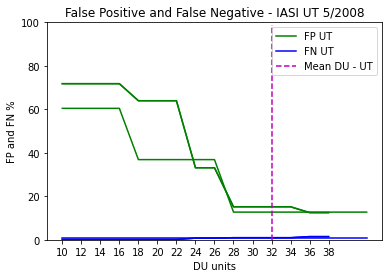

In [142]:

#t_p_plot = np.where(np.array(all_true_positives_c) > 0, all_true_positives_c, np.nan)

fig, ax = plt.subplots(1,1)

##ax.plot( np.arange(len(all_true_positives_c)), all_true_positives_c, label="True Positives")
#ax.plot( np.arange(len(all_false_positives_c)), all_false_positives_c, label="False Positives")
#ax.plot( np.arange(len(all_false_negatives_c)), all_false_negatives_c, label="False Negatives")

#for i,fps in enumerate(lt_fp):
#  if i == 0:
#    ax.plot( np.arange(len(fps)), fps, c="b", label="FP LT")
#  ax.plot( np.arange(len(fps)), fps, c="b")
#for fns in lt_fn[:]:
#  ax.plot( np.arange(len(fns)), fns, c="b")


for i,fps in enumerate(ut_fp):
  if i == 0:
    ax.plot( np.arange(len(fps)), fps, c="g", label="FP UT")
  ax.plot( np.arange(len(fps)), fps, c="g")
for i,fps in enumerate(ut_fn):
  if i == 0:
    ax.plot( np.arange(len(fps)), fps, c="b", label="FN UT")
  ax.plot( np.arange(len(fps)), fps, c="b")

#du_thresh_lt, du_best_value_lt = get_best_DU(lt_fp,lt_fn, "LT")
du_thresh_ut, du_best_value_ut = get_best_DU(ut_fp,ut_fn, "UT")

#line_lt = np.full((100,), int(du_thresh_lt))
#plt.plot(line_lt, np.arange(len(line_lt)), "--", label="Mean DU - LT", c="r")

line_ut = np.full((100,), int(du_thresh_ut))
plt.plot(line_ut, np.arange(len(line_ut)), "--", label="Mean DU - UT", c="m")

ax.set_title('False Positive and False Negative - IASI UT 5/2008')# + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
ax.set_xlabel("DU units")
ax.set_ylabel("FP and FN %")
ax.set_ylim([0,100])
plt.xticks(np.arange(len(ut_fp[0])), np.arange(10,45,2))

ax.legend()
plt.show()

In [143]:
print(int(du_best_value_ut))

32


In [144]:
pollution_ut = get_ut_final_clusters(all_foreground_ut,all_masks_ut,all_images_cluster_ut,int(du_best_value_ut),"UT",2008,5,6)

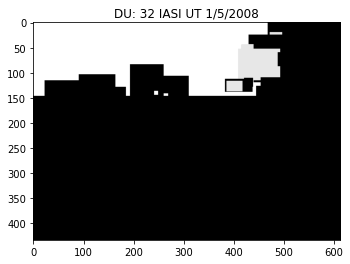

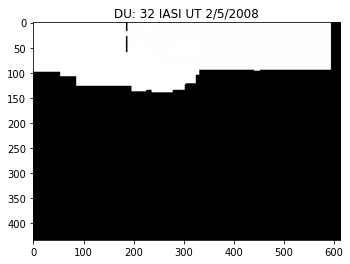

In [145]:
for i in range(len(pollution_ut)):
  fig, ax = plt.subplots(1,1)
  ax.set_title("DU: " + str(int(du_best_value_ut)) + " IASI UT " + str(i+1) + "/5/2008")
  ax.imshow(pollution_ut[i], cmap="gray")

In [146]:

def compute_clusters_lt(pollution2, image_gray, WEIGHT,N_CLUSTERS ):
  image_bgr = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR) # reupdate the lt image
  image, foreground, background = pollution2.filter_image(image_gray)
  image,image_rbg,image_masked = pollution2.filter_image_for_mser(image,foreground)
  
  regions_mser, boxes_mser = pollution2.get_mser_regions(image_rbg)
  regx, regy, regs, polys, lines, values = pollution2.set_mser_regions(image_masked, regions_mser)
  pollution2.create_label(image_masked,regx, regy, values)

  _, image_projected = pollution2.load_image_from_files("proj-" + pollution2.get_image_name())
  image_projected = np.where(image_projected == 255, 0, image_projected)
  image_projected = cv2.morphologyEx(image_projected, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations = 1)
  image_projected_mask = ma.masked_values(image_projected, 0.)

  labels_cc, num_cc = pollution2.reconstruct_connected_component(image_projected_mask)
  centroids, grays_values, areas_partition, boxes_partition, ids_valid_regions = pollution2.reconstruct_region_props(image_projected_mask, labels_cc)

  X, weights = pollution2.create_X(image_projected,centroids,grays_values,WEIGHT)
  cluster_labels, cluster_centers, model = pollution2.classify_regions(X,weights,N_CLUSTERS)
  image_cluster = pollution2.get_image_cluster(image_projected,cluster_labels, boxes_partition)

  return foreground, image_masked, image_cluster


def compare_with_lt(year,month,day_to_test, pollution_ut, du_best_value_ut, isInner=False):
  WEIGHT = 2
  N_CLUSTERS = 5

  pollution2 = PollutionTracker()
  pollution2.set_year(year)
  pollution2.set_month(month)
  pollution2.set_day(day_to_test)
  pollution2.set_image_type("LT")
  pollution2.set_vmin(10)
  pollution2.set_vmax(35)
  pollution2.set_image_name("levels")
  pollution2.set_weight_gray_values(1)
  pollution2.set_cluster_value(30)
  pollution2.set_pixel_size(0.25,.125)
  pollution2.get_image_by_leves()
  _ , image_gray = pollution2.load_image_from_files(pollution2.get_image_name())
  image_gray2 = image_gray.copy()

  image_gray_in = np.where(pollution_ut[day_to_test - 1] == 0, 0, image_gray) # pixels inside the region UT
  image_gray_out = np.where(pollution_ut[day_to_test - 1] != 0, 0, image_gray) # remove pixels highest region

  foreground_in, image_masked_in, image_cluster_in = compute_clusters_lt(pollution2, image_gray_in, WEIGHT, N_CLUSTERS)
  foreground_out, image_masked_out, image_cluster_out = compute_clusters_lt(pollution2, image_gray_out, WEIGHT, N_CLUSTERS)

  lt_fp_in, lt_fn_in = compare_with_ground_truth([foreground_in], [image_masked_in], [image_cluster_in], year, month, "LT",False, int(du_best_value_ut))
  lt_fp_out, lt_fn_out = compare_with_ground_truth([foreground_out], [image_masked_out], [image_cluster_out], year, month, "LT",False, int(du_best_value_ut))
  
  du_thresh_lt_in, du_best_value_lt_in = get_best_DU(lt_fp_in,lt_fn_in, "LT",int(du_best_value_ut))
  du_thresh_lt_out, du_best_value_lt_out = get_best_DU(lt_fp_out,lt_fp_out, "LT",int(du_best_value_ut))

  #if du_best_value_lt_in < du_best_value_lt_out:
  #  higher = du_best_value_lt_in
  #else:
  #  higher = du_best_value_lt_out

  higher = 26. # np.mean([du_best_value_lt_in, du_best_value_lt_out])

  pollution_lt_in = get_ut_final_clusters([foreground_in],[image_masked_in],[image_cluster_in],int(higher),"LT",year,month,N_CLUSTERS)
  pollution_lt_out = get_ut_final_clusters([foreground_out],[image_masked_out],[image_cluster_out],int(higher),"LT",year,month,N_CLUSTERS)

  for i in range(len(pollution_lt_in)):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,8))
    ax1.set_title("Inner DU: " + str(higher) + " " + pollution2.get_image_datename())
    ax1.imshow(pollution_lt_in[i], cmap="gray")
    ax2.set_title("Outer DU: " + str(higher) + " " + pollution2.get_image_datename())
    ax2.imshow(pollution_lt_out[i], cmap="gray")

reading info ...
data have been read correctly
REGIONS found with MSER 154
Total connected components 1752
props 1752
clustering...
Cluster finished.
REGIONS found with MSER 346
Total connected components 3289
props 3289
clustering...
Cluster finished.
Class finished
reading info ...
data have been read correctly
REGIONS found with MSER 139
Total connected components 1574
props 1574
clustering...
Cluster finished.
REGIONS found with MSER 195
Total connected components 1536
props 1536
clustering...
Cluster finished.
Class finished


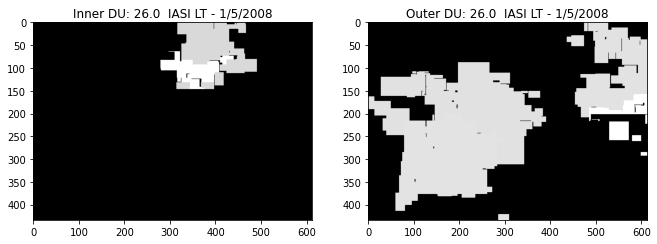

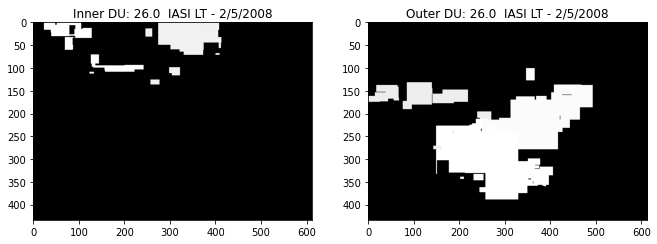

In [147]:
for i in range(1,3):
  compare_with_lt(2008,5,i,pollution_ut,du_best_value_ut,False)

In [ ]:
WEIGHT = 2
N_CLUSTERS = 15
day_to_test = 7

pollution2 = PollutionTracker()
pollution2.set_year(2008)
pollution2.set_month(5)
pollution2.set_day(day_to_test)
pollution2.set_image_type("LT")
pollution2.set_vmin(10)
pollution2.set_vmax(35)
pollution2.set_image_name("levels")
pollution2.set_weight_gray_values(1)
pollution2.set_cluster_value(30)
pollution2.set_pixel_size(0.25,.125)
pollution2.get_image_by_leves()

Class finished
reading info ...
data have been read correctly


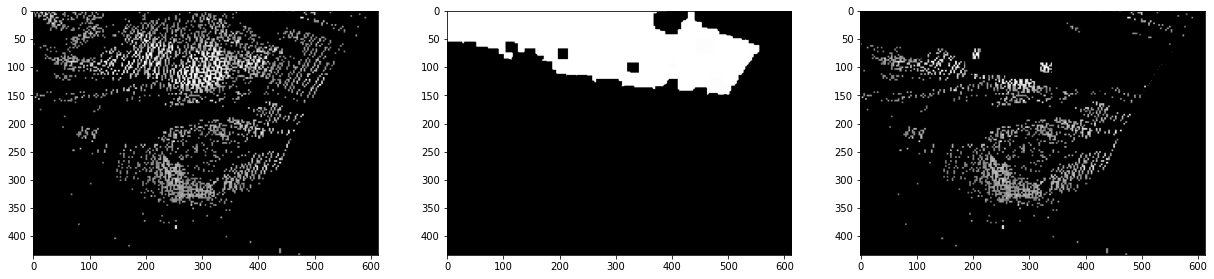

In [ ]:
_ , image_gray = pollution2.load_image_from_files(pollution2.get_image_name())
#pollution2.plot_original_image()
image_gray2 = image_gray.copy()
image_gray = np.where(pollution_ut[day_to_test - 1] != 0, 0, image_gray) # remove pixels highest region
image_bgr = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2BGR) # reupdate the lt image

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(21,10))
ax0.imshow(image_gray2, cmap="gray")
ax1.imshow(pollution_ut[day_to_test - 1], cmap="gray")
ax2.imshow(image_gray, cmap="gray")

REGIONS found with MSER 54
Class finished
Class finished
Total connected components 110


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Regions reconstructed 110
clustering...
Cluster finished.


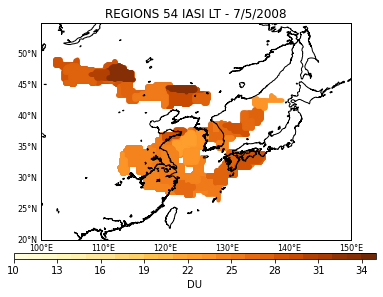

In [ ]:
image, foreground, background = pollution2.filter_image(image_gray)
image,image_rbg,image_masked = pollution2.filter_image_for_mser(image,foreground)
regions_mser, boxes_mser = pollution2.get_mser_regions(image_rbg)

regx, regy, regs, polys, lines, values = pollution2.set_mser_regions(image_masked, regions_mser)
pollution2.plot_mser_final_regions(image_masked, regx, regy, values)

image_projected, image_projected_mask = pollution2.create_label_map(image, regions_mser)
labels_cc, num_cc = pollution2.reconstruct_connected_component(image_projected_mask)
centroids, grays_values, areas_partition, boxes_partition, ids_valid_regions = pollution2.reconstruct_region_props(image,labels_cc,10,10)
X, weights = pollution2.create_X(image_projected,centroids,grays_values,WEIGHT)
cluster_labels, cluster_centers, model = pollution2.classify_regions(X,weights,N_CLUSTERS)
image_cluster = pollution2.get_image_cluster(labels_cc,cluster_labels)

In [ ]:
lt_fp2, lt_fn2 = compare_with_ground_truth([foreground], [image_masked], [image_cluster], 2008, 5, "LT",False, int(du_best_value_ut))

In [ ]:
du_thresh_lt2, du_best_value_lt2 = get_best_DU(lt_fp2,lt_fn2, "LT",int(du_best_value_ut))
print(du_thresh_lt2, du_best_value_lt2)

13.0 36.0


In [ ]:
pollution_lt = get_ut_final_clusters([foreground],[image_masked],[image_cluster],int(du_best_value_lt2),"LT",2008,5,N_CLUSTERS)

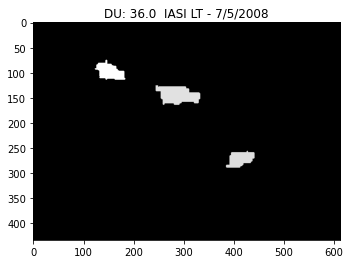

In [ ]:
for i in range(len(pollution_lt)):
  fig, ax = plt.subplots(1,1)
  ax.set_title("DU: " + str(du_best_value_lt2) + " " + pollution2.get_image_datename())
  ax.imshow(pollution_lt[i], cmap="gray")

In [ ]:
test_i_ut = all_input_ut.copy()
test_l_ut = all_labels_ut.copy()
test_w_ut = all_weights_ut.copy()
test_target_ut = all_regions_target_ut.copy()

export_input_ut_x = ['X_m']
export_input_ut_y = ['Y_m']
export_input_ut_z = ['Z_m']
export_label_ut = ['label']
export_weight_ut = ['w']
export_day_ut = ['day']
export_du_ut = ['DU']
export_center_ut = ['centroid']
export_target_ut = ['y_target']

for i in range(len(test_i_ut)):
  
  for c in test_i_ut[i][:,0]:
    export_input_ut_x.append(c)
    # append the day also
    export_day_ut.append((i+1))
  
  for c in test_i_ut[i][:,1]:
    export_input_ut_y.append(c)
  
  for c in test_i_ut[i][:,2]:
    export_input_ut_z.append(c)

  for l in test_l_ut[i]:
    export_label_ut.append(l)

  for w in test_w_ut[i]:
    export_weight_ut.append(w)

  for du in all_grays_vals_ut[i]:
    export_du_ut.append(w)

  for c in all_centroids_vals_ut[i]:
    export_center_ut.append(c)

  for y in test_target_ut[i]:
    export_target_ut.append(y)
    
np.savetxt('export_ut.csv', [p for p in zip(export_input_ut_x, 
                                            export_input_ut_y,
                                            export_input_ut_z,
                                            export_label_ut,
                                            export_weight_ut,
                                            export_day_ut,
                                            export_du_ut,
                                            export_target_ut
                                            )], delimiter=',', fmt='%s')

In [ ]:
test_i_lt = all_input_lt.copy()
test_l_lt = all_labels_lt.copy()
test_w_lt = all_weights_lt.copy()
test_target_lt = all_regions_target_lt.copy()

export_input_lt_x = ['X_m']
export_input_lt_y = ['Y_m']
export_input_lt_z = ['Z_m']
export_label_lt = ['label']
export_weight_lt = ['w']
export_day_lt = ['day']
export_du_lt = ['DU']
export_center_lt = ['centroid']
export_target_lt = ['y_target']

for i in range(len(test_i_lt)):
  
  for c in test_i_lt[i][:,0]:
    export_input_lt_x.append(c)
    # append the day also
    export_day_lt.append((i+1))
  
  for c in test_i_lt[i][:,1]:
    export_input_lt_y.append(c)
  
  for c in test_i_lt[i][:,2]:
    export_input_lt_z.append(c)

  for l in test_l_lt[i]:
    export_label_lt.append(l)

  for w in test_w_lt[i]:
    export_weight_lt.append(w)

  for du in all_grays_vals_lt[i]:
    export_du_lt.append(w)

  for c in all_centroids_vals_lt[i]:
    export_center_lt.append(c)

  for y in test_target_lt[i]:
    export_target_lt.append(y)

np.savetxt('export_lt.csv', [p for p in zip(export_input_lt_x, 
                                            export_input_lt_y,
                                            export_input_lt_z,
                                            export_label_lt,
                                            export_weight_lt,
                                            export_day_lt,
                                            export_du_lt,
                                            export_target_lt)], delimiter=',', fmt='%s')

In [ ]:
fp_test_e = lt_fp.copy()
fn_test_e = lt_fn.copy()

export_fp_name = ['FP']
export_fn_name = ['FN']

for fps in fp_test_e:
  for fp in fps:
    export_fp_name.append(fp)

for fns in fn_test_e:
  for fn in fns:
    export_fn_name.append(fn)

np.savetxt('export_fp_fn.csv', [p for p in zip(export_fp_name, export_fn_name)], delimiter=',', fmt='%s')

In [ ]:
test_c_lt = all_centers_lt.copy()

export_centers_lt_x = ['center_x']
export_centers_lt_y = ['center_y']
export_centers_lt_z = ['center_z']
export_day_c = ['day']

for i in range(len(test_c_lt)):
  for c in test_c_lt[i][:,0]:
    export_centers_lt_x.append(c)
    # append the day also
    export_day_c.append((i+1))
  for c in test_c_lt[i][:,1]:
    export_centers_lt_y.append(c)
  for c in test_c_lt[i][:,2]:
    export_centers_lt_z.append(c)

np.savetxt('export_centers_lt_dec2008.csv', [p for p in zip(export_centers_lt_x, export_centers_lt_y,export_centers_lt_z,export_day_c)], delimiter=',', fmt='%s')

In [ ]:
test_c_ut = all_centers_ut.copy()

export_centers_ut_x = ['center_x']
export_centers_ut_y = ['center_y']
export_centers_ut_z = ['center_z']
export_day_c = ['day']

for i in range(len(test_c_ut)):
  for c in test_c_ut[i][:,0]:
    export_centers_ut_x.append(c)
    # append the day also
    export_day_c.append((i+1))
  for c in test_c_ut[i][:,1]:
    export_centers_ut_y.append(c)
  for c in test_c_ut[i][:,2]:
    export_centers_ut_z.append(c)

np.savetxt('export_centers_ut_dec2008.csv', [p for p in zip(export_centers_ut_x, export_centers_ut_y,export_centers_ut_z,export_day_c)], delimiter=',', fmt='%s')